# Exercises

In [1]:
!pip install deepxde &> /dev/null

In [2]:
import tensorflow.compat.v1 as tf
import deepxde as dde

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [3]:
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps as cm
from tqdm import tqdm
import scipy
from numpy.polynomial.hermite import hermval

## A simple ODE

$$\frac{dy}{dx} = \cos(\omega x), \quad x\in [-\pi , \pi],$$
with $y(0)=0$.

The exact solution is $y(x)=\frac{1}{\omega}\sin(\omega x)$.

In [ ]:
omega = 10
x_max = np.pi

def ode(x, y):
    y_x = dde.grad.jacobian(y, x, i=0, j=0)
    return y_x - tf.cos(omega*x)

geom = dde.geometry.TimeDomain(-x_max, x_max)

def boundary(_, on_initial):
    return on_initial

ic= dde.icbc.IC(geom, lambda x: 0, boundary, component=0)

data = dde.data.TimePDE(
    geom, ode,
    ic_bcs=[ic],
    num_domain=400, num_boundary=2,
)
net = dde.nn.FNN([1] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.336122 s

'compile' took 1.696968 s

Training model...

Step      Train loss              Test loss               Test metric
0         [5.66e-01, 4.65e-01]    [5.66e-01, 4.65e-01]    []  
1000      [5.01e-01, 1.77e-07]    [5.01e-01, 1.77e-07]    []  
2000      [5.01e-01, 2.60e-11]    [5.01e-01, 2.60e-11]    []  
3000      [5.01e-01, 1.74e-09]    [5.01e-01, 1.74e-09]    []  
4000      [5.01e-01, 1.05e-09]    [5.01e-01, 1.05e-09]    []  
5000      [5.01e-01, 5.88e-10]    [5.01e-01, 5.88e-10]    []  
6000      [5.01e-01, 4.15e-10]    [5.01e-01, 4.15e-10]    []  
7000      [5.00e-01, 5.10e-06]    [5.00e-01, 5.10e-06]    []  
8000      [5.00e-01, 4.32e-10]    [5.00e-01, 4.32e-10]    []  
9000      [3.44e-01, 4.82e-08]    [3.44e-01, 4.82e-08]    []  
10000     [1.93e-01, 5.92e-07]    [1.93e-01, 5.92e-07]    []  
11000     [4.06e-03, 2.65e-07]    [4.06e-03, 2.65e-07]    []  
12000     [7.38e-04, 1.93e-08]    [7.38e-04, 1.93e-08]    []  
13000     [2.42e-04, 7.56e-10]    [2.42e

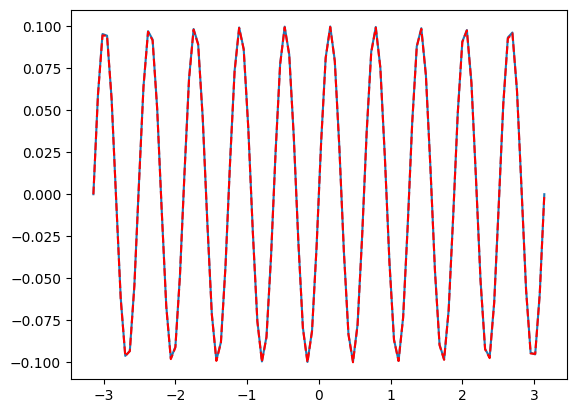

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=20000)

x = np.linspace(-x_max, x_max, 100)
y_true = np.sin(omega*x)/omega
y_pred = model.predict(x.reshape(100, 1))
plt.plot(x, y_true)
plt.plot(x, y_pred, "r--")
plt.show()

## Heat equation

$$w_t - aw_{xx}=0,\qquad (x,t)\in (0,1)\times (0,1),$$
with initial condition
$$ w(x,0) = x^2+1,$$
and boundary conditions
$$ w(0,t) = 2at + 1\qquad \text{and}\qquad w(1,t)= 2at +2.$$
The exact solution is
$$w(x,t)=x^2 +2at+1.$$

## A system of linear PDEs

Consider the system \begin{array}{l}
v_t - a v_{xx} = -v ,\\
w_t - a w_{xx} =  v - 2 w.
\end{array}
with initial conditions
\begin{array}{l}
v(x,0) = x^2+1,\\
w(x,0) = 0,
\end{array}
and boundary conditions
\begin{array}{l}
v(0,t) = \left(2at+1\right)e^{-t}, \\
v(1,t) = \left(2at+2\right)e^{-t},\\
w(0,t) = \left(2at+1\right)\left(e^{-t}-e^{-2t}\right), \\
w(1,t) = \left(2at+2\right)\left(e^{-t}-e^{-2t}\right).
\end{array}
The exact solution of the system is
\begin{array}{l}
v(x,t)= \left(x^2 + 2at + 1\right)e^{- t},\\
w(x,t)= \left(x^2 + 2at + 1\right)\left(e^{- t}-  e^{-2t}\right).
\end{array}

In [ ]:
a = 2
x_max = 1
t_max = 1

def v_sol(X, T):
    return (X**2 + 2*a*T + 1)*np.exp(-T)
def w_sol(X, T):
    return (X**2 + 2*a*T + 1)*(np.exp(-T) - np.exp(-2*T))
def sys_sol(Z):
    v = v_sol(Z[:,:1], Z[:,1:])
    w = w_sol(Z[:,:1], Z[:,1:])
    return np.stack([v.flatten(), w.flatten()], 1)

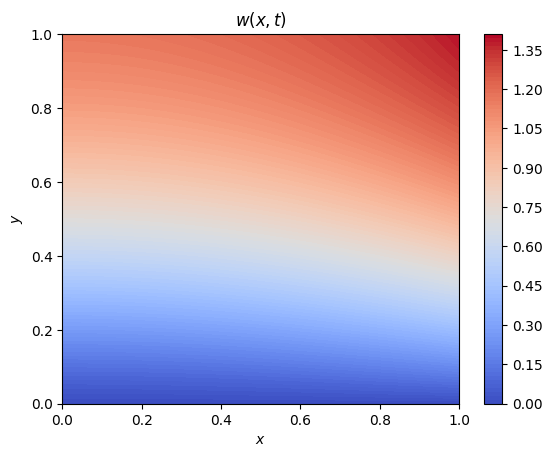

In [ ]:
x = np.linspace(0, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
plt.contourf(X, T, w_sol(X, T), cmap="coolwarm", levels=100)
plt.title("$w(x,t)$")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.colorbar()
plt.show()

In [ ]:
def eqs_system(X, Y):
  # y = (u, ut)
    v, w = Y[:,:1], Y[:,1:]
    v_xx = dde.grad.hessian(Y, X, i=0, j=0, component=0)
    w_xx = dde.grad.hessian(Y, X, i=0, j=0, component=1)
    v_t = dde.grad.jacobian(Y, X, i=0, j=1)
    w_t = dde.grad.jacobian(Y, X, i=1, j=1)
    return v_t - a*v_xx + v, w_t - a*w_xx - v + 2*w

geom = dde.geometry.Interval(0, x_max)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(_, on_initial):
    return on_initial

ic1 = dde.icbc.IC(geomtime, lambda X: X[:,0:1]**2 + 1, boundary, component=0)
ic2 = dde.icbc.IC(geomtime, lambda X: 0, boundary, component=1)

def boundary_left(X, on_boundary):
    return dde.utils.isclose(X[0], 0.0)
def boundary_right(X, on_boundary):
    return dde.utils.isclose(X[0], 1.0)

bc_left_v = dde.icbc.DirichletBC(geom,
                               lambda X: (2*a*X[:,1:2] + 1)*tf.exp(-X[:,1:2]),
                               boundary_left, component=0)
bc_right_v = dde.icbc.DirichletBC(geom,
                                lambda X: (2*a*X[:,1:2] + 2)*tf.exp(-X[:,1:2]),
                                boundary_right, component=0)

bc_left_w = dde.icbc.DirichletBC(
    geom,
    lambda X: (2*a*X[:,1:2] + 1)*(tf.exp(-X[:,1:2]) - tf.exp(-2*X[:,1:2])),
    boundary_left, component=1,
    )
bc_right_w = dde.icbc.DirichletBC(
    geom,
    lambda X: (2*a*X[:,1:2] + 2)*(tf.exp(-X[:,1:2]) - tf.exp(-2*X[:,1:2])),
    boundary_right, component=1,
    )

data = dde.data.TimePDE(
    geomtime, eqs_system,
    ic_bcs=[ic1, ic2, bc_left_v, bc_left_w, bc_right_v, bc_right_w],
    num_domain=400, num_boundary=160, num_initial=160,
)
net = dde.nn.FNN([2] + [32] * 4 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=20000)

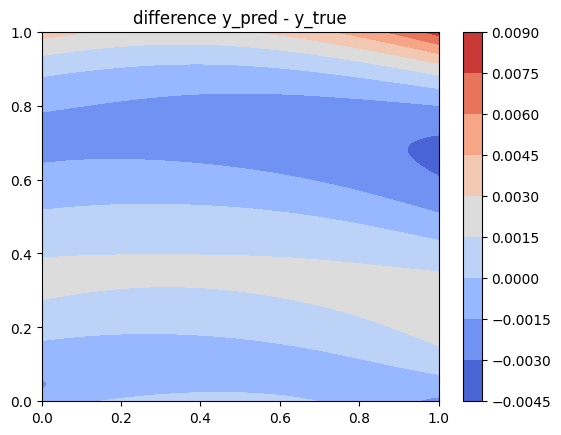

In [ ]:
x = np.linspace(0, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
W = model.predict(np.stack([X.flatten(), T.flatten()], 1))
plt.contourf(X, T, W[:,:1].reshape(100, 100) - v_sol(X,T), cmap="coolwarm")
plt.title("difference y_pred - y_true")
plt.colorbar()
plt.show()

## Coupled Spring Mass ODE System

\begin{align}
m_1 x_1''(t) &= -k_1 x_1(t) + k_2(x_2(t) - x_1(t)),\\
m_2 x_2''(t) &= -k_2 (x_2(t) - x_1(t))+ k_3(x_3(t) - x_2(t)),\\
m_3 x_3''(t) &= -k_3 (x_3(t) - x_2(t)) - k_4 x_3(t).
\end{align}
with the initial conditions and parameters
\begin{align}
(m_1, m_2, m_3) &= (1, 1, 1),\\
(k_1, k_2, k_3, k_4) &= (2, 1, 1, 2),\\
(x_1(0), x_2(0), x_3(0)) &= (1, 0, 0),\\
(x_1'(0), x_2'(0), x_3'(0)) &= (0, 0, 0).
\end{align}

 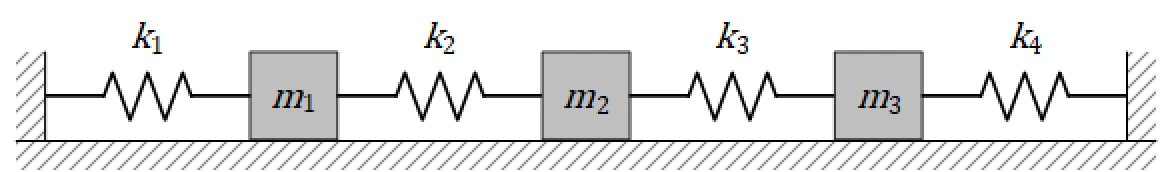

To solve this system numerically of second-order ordinary differential equations, we can first convert it into a system of first-order ODEs. Define new variables  $v_1 = x_1', v_2 = x_2'$ and $v_3=x_3'$.Then the system becomes
\begin{align*}
\frac{dx_1}{dt} &= v_1, \\
\frac{dv_1}{dt} &= -\frac{k_1}{m_1} x_1 + \frac{k_2}{m_1}(x_2 - x_1), \\
\frac{dx_2}{dt} &= v_2, \\
\frac{dv_2}{dt} &= -\frac{k_2}{m_2}(x_2 - x_1) + \frac{k_3}{m_2}(x_3 - x_2), \\
\frac{dx_3}{dt} &= v_3, \\
\frac{dv_3}{dt} &= -\frac{k_3}{m_3}(x_3 - x_2) - \frac{k_4}{m_3} x_3.
\end{align*}
Now, we use Runge-Kutta method, to solve this system. Let's denote $Y = [x_1, v_1, x_2, v_2, x_3, v_3]$ as the vector of variables. The initial conditions become $Y(0)=[1,0,0,0,0,0]$. The differential equations can be expressed in the matrix form $Y'=F(t,Y)$. The Runge-Kutta method then updates $Y$ at each time step according to:

\begin{align*}
\sigma_1 &= h \cdot F(t_n, Y_n), \\
\sigma_2 &= h \cdot F\left(t_n + \frac{h}{2}, Y_n + \frac{\sigma_1}{2}\right), \\
\sigma_3 &= h \cdot F\left(t_n + \frac{h}{2}, Y_n + \frac{\sigma_2}{2}\right), \\
\sigma_4 &= h \cdot F(t_n + h, Y_n + \sigma_3),
\end{align*}

where $h$ is the time step, $t_n$ is the current time, and $Y_n$ is the current value of $Y$. The updated value is given by:

$$Y_{n+1} = Y_n + \frac{\sigma_1 + 2\sigma_2 + 2\sigma_3 + \sigma_4}{6}.$$
Let's implement this using SciPy:


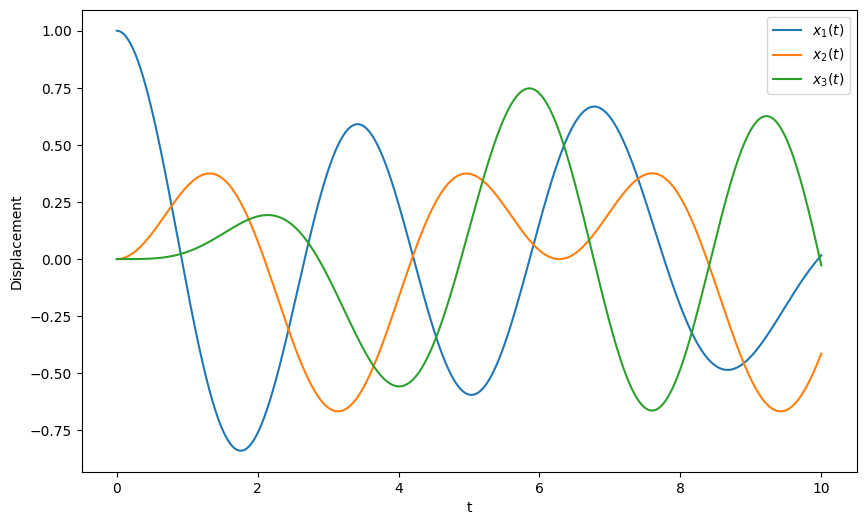

In [ ]:
t_max = 10

# Define the system of ODEs
def system(t, Y, m, k):
    x1, v1, x2, v2, x3, v3 = Y
    m1, m2, m3 = m
    k1, k2, k3, k4 = k

    dx1dt = v1
    dv1dt = -(k1/m1) * x1 + (k2/m1) * (x2 - x1)

    dx2dt = v2
    dv2dt = -(k2/m2) * (x2 - x1) + (k3/m2) * (x3 - x2)

    dx3dt = v3
    dv3dt = -(k3/m3) * (x3 - x2) - (k4/m3) * x3

    return [dx1dt, dv1dt, dx2dt, dv2dt, dx3dt, dv3dt]

# Set up initial conditions and parameters
m = [1, 1, 1]
k = [2, 1, 1, 2]
initial_conditions = [1, 0, 0, 0, 0, 0]

# Solve the system using solve_ivp
solution = solve_ivp(
    fun=lambda t, Y: system(t, Y, m, k),
    t_span=(0, t_max),
    y0=initial_conditions,
    method='RK45',
    dense_output=True
)

# Extract the solution
t = np.linspace(0, t_max, 1000)
Y = solution.sol(t)

plt.figure(figsize=(10, 6))
plt.plot(t, Y[0], label='$x_1(t)$')
plt.plot(t, Y[2], label='$x_2(t)$')
plt.plot(t, Y[4], label='$x_3(t)$')
plt.xlabel('t')
plt.ylabel('Displacement')
plt.legend()
plt.show()


Solve the above system using a PINN and compare your solution to the given numerical solution.

\begin{align}
m_1 x_1''(t) &= -k_1 x_1(t) + k_2(x_2(t) - x_1(t)),\\
m_2 x_2''(t) &= -k_2 (x_2(t) - x_1(t))+ k_3(x_3(t) - x_2(t)),\\
m_3 x_3''(t) &= -k_3 (x_3(t) - x_2(t)) - k_4 x_3(t).
\end{align}

In [ ]:
k1, k2, k3, k4 = k
m1, m2, m3 = m

def spring_system(t, x):
    x1, x2, x3 = x[:,:1], x[:,1:2], x[:,2:]
    x1_tt = dde.grad.hessian(x, t, i=0, j=0, component=0)
    x2_tt = dde.grad.hessian(x, t, i=0, j=0, component=1)
    x3_tt = dde.grad.hessian(x, t, i=0, j=0, component=2)
    a = m1*x1_tt + k1*x1 - k2*(x2 - x1)
    b = m2*x2_tt + k2*(x2 - x1) - k3*(x3 - x2)
    c = m3*x3_tt + k3*(x3 - x2) + k4*x3
    return a, b, c

geom = dde.geometry.TimeDomain(0, t_max)

def boundary(t, _):
    return dde.utils.isclose(t[0], 0.0)

ic1= dde.icbc.IC(geom, lambda x: 1, boundary, component=0)
ic2= dde.icbc.IC(geom, lambda x: 0, boundary, component=1)
ic3= dde.icbc.IC(geom, lambda x: 0, boundary, component=2)

def derivative1_ic(t, x, _):
    return dde.grad.jacobian(x, t, i=0, j=None)
def derivative2_ic(t, x, _):
    return dde.grad.jacobian(x, t, i=1, j=None)
def derivative3_ic(t, x, _):
    return dde.grad.jacobian(x, t, i=2, j=None)

ic4 = dde.icbc.OperatorBC(geom, derivative1_ic, boundary)
ic5 = dde.icbc.OperatorBC(geom, derivative2_ic, boundary)
ic6 = dde.icbc.OperatorBC(geom, derivative3_ic, boundary)

data = dde.data.TimePDE(
    geom, spring_system,
    ic_bcs=[ic1, ic2, ic3, ic4, ic5, ic6],
    num_domain=400, num_boundary=2,
)
net = dde.nn.FNN([1] + [64]*4 + [3], "sin", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=4000)

Compiling model...
'compile' took 2.645380 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
4000      [5.07e-03, 3.52e-03, 3.70e-03, 6.58e-04, 3.65e-04, 2.02e-04, 5.39e-06, 4.96e-07, 6.32e-07]    [5.07e-03, 3.52e-03, 3.70e-03, 6.58e-04, 3.65e-04, 2.02e-04, 5.39e-06, 4.96e-07, 6.32e-07]    []  
5000      [1.87e-04, 1.33e-04, 3.46e-04, 5.97e-06, 4.02e-06, 2.59e-06, 1.43e-08, 2.50e-08, 4.99e-09]    [1.87e-04, 1.33e-04, 3.46e-04, 5.97e-06, 4.02e-06, 2.59e-06, 1.43e-08, 2.50e-08, 4.99e-09]    []  
6000      [2.09e-04, 1.13e-04, 1.14e-04, 4.45e-07, 2.70e-07, 1.06e-07, 1.15e-06, 4.09e-06, 1.14e-06]    [2.09e-04, 1.13e-04, 1.14e-04, 4.45e-07, 2.70e-07, 1.06e-07, 1.15e-06, 4.09e-06, 1.14e-06]    []  
7000      [4.89e-05, 2.41e-05, 4.22e-05, 9.27e-08, 1.74e-08, 9.00e-09, 1.16e-10, 1.94e-09, 1.76e-10]    [4.89e-05, 2

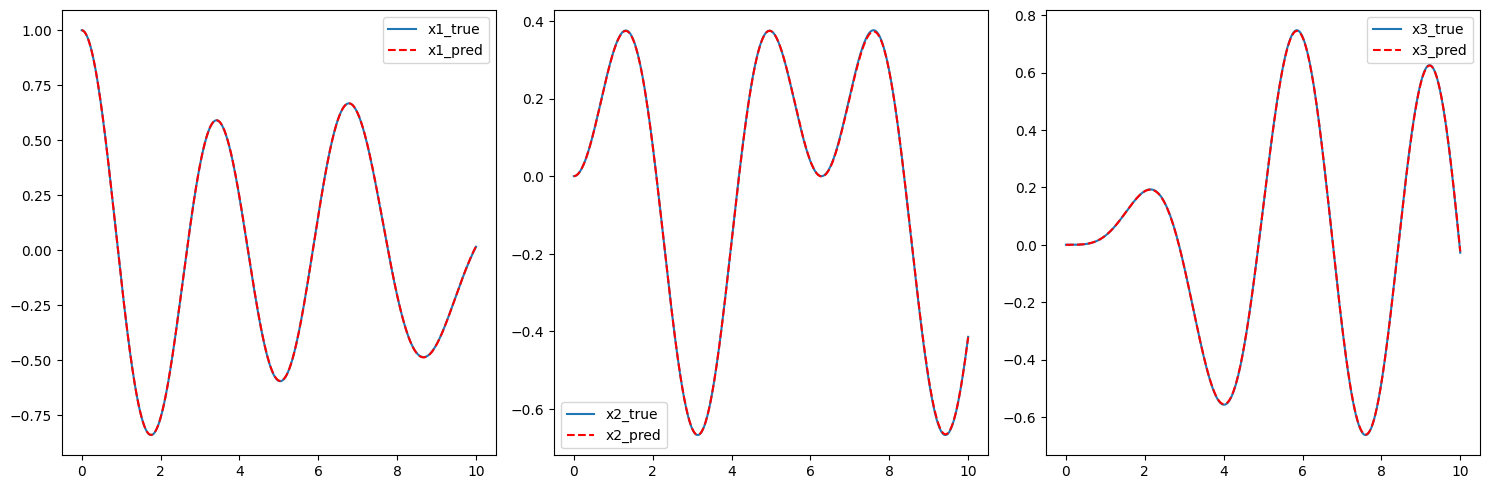

In [ ]:
t = np.linspace(0, t_max, 1000)
x_pred = model.predict(t.reshape(1000, 1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# x1(t)
axs[0].plot(t, Y[0], label='x1_true')
axs[0].plot(t, x_pred[:,0], "r--", label='x1_pred')
axs[0].legend()

# x2(t)
axs[1].plot(t, Y[2], label='x2_true')
axs[1].plot(t, x_pred[:,1], "r--", label='x2_pred')
axs[1].legend()

# x3(t)
axs[2].plot(t, Y[4], label='x3_true')
axs[2].plot(t, x_pred[:,2], "r--", label='x3_pred')
axs[2].legend()

plt.tight_layout()
plt.show()

Plot the total energy!!!

##Poisson Equation



### Example 1

Give an approximation to the Poisson equation
\begin{equation}  \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial x^2}=4,\qquad x,y\in [0,1],\end{equation}
with the boundary conditions:
\begin{array}{l} u(x,0)=x^2, \ \ \ \ \ & 0 \leq x \leq 1,\\
u(x,1)=x^2+1, \ \ \ \ \ & 0 \leq x \leq 1,\\
 u(0,y)=y^2, \ \ \ \ \ & 0 \leq y \leq 1,\\
 u(1,y)=y^2+1, \ \ \ \ \ & 0 \leq y \leq 1.\end{array}

The exact solution is $u(x,y) = x^2 + y^2$.

In [ ]:
def poisson1(z, u):
    # z = (x, y)
    du_xx = dde.grad.hessian(u, z, i=0, j=0)
    du_yy = dde.grad.hessian(u, z, i=1, j=1)
    return du_xx + du_yy - 4

geom = dde.geometry.Rectangle([0, 0], [1, 1])

def boundary_l(z, _):
    return dde.utils.isclose(z[0], 0.0)
def boundary_r(z, _):
    return dde.utils.isclose(z[0], 1.0)
def boundary_t(z, _):
    return dde.utils.isclose(z[1], 1.0)
def boundary_b(z, _):
    return dde.utils.isclose(z[1], 0.0)

bc1 = dde.icbc.DirichletBC(geom, lambda z: z[:,1:2]**2, boundary_l)
bc2 = dde.icbc.DirichletBC(geom, lambda z: z[:,1:2]**2 + 1, boundary_r)
bc3 = dde.icbc.DirichletBC(geom, lambda z: z[:,0:1]**2 + 1, boundary_t)
bc4 = dde.icbc.DirichletBC(geom, lambda z: z[:,0:1]**2, boundary_b)

data = dde.data.PDE(
    geom,
    poisson1,
    [bc1, bc2, bc3, bc4],
    num_domain=2000,
    num_boundary=500
)

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=4000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.143999 s

'compile' took 1.496833 s

Training model...

0         [1.46e+01, 2.55e-01, 3.14e+00, 2.79e+00, 4.24e-01]    [1.46e+01, 2.55e-01, 3.14e+00, 2.79e+00, 4.24e-01]    []  
1000      [4.88e-04, 1.18e-05, 1.22e-05, 1.26e-05, 9.19e-06]    [4.88e-04, 1.18e-05, 1.22e-05, 1.26e-05, 9.19e-06]    []  
2000      [2.70e-04, 9.57e-06, 8.75e-06, 5.99e-06, 8.90e-06]    [2.70e-04, 9.57e-06, 8.75e-06, 5.99e-06, 8.90e-06]    []  
3000      [2.14e-04, 2.37e-06, 1.61e-06, 1.39e-06, 1.65e-06]    [2.14e-04, 2.37e-06, 1.61e-06, 1.39e-06, 1.65e-06]    []  
4000      [1.31e-04, 2.21e-07, 1.41e-07, 2.47e-07, 7.29e-08]    [1.31e-04, 2.21e-07, 1.41e-07, 2.47e-07, 7.29e-08]    []  

Best model at step 4000:
  train loss: 1.32e-04
  test loss: 1.32e-04
  test metric: []

'train' took 306.623653 s



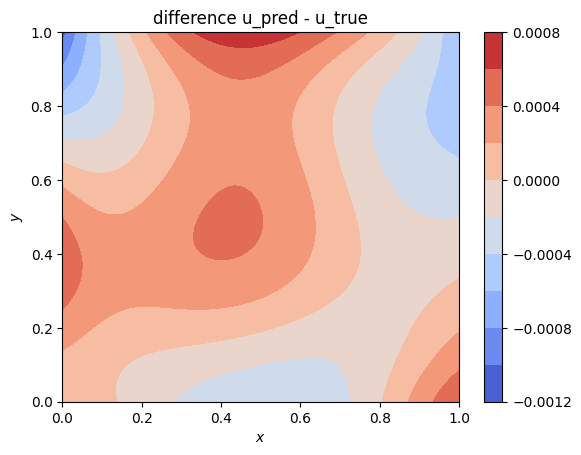

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x,y)
z = np.stack([X.flatten(), Y.flatten()], 1)
u_pred = model.predict(z).reshape(100, 100)
u_true = X**2 + Y**2
plt.contourf(X, Y,  u_pred - u_true, cmap="coolwarm", levels=10)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("difference u_pred - u_true")
plt.show()

Training points:

In [ ]:
plt.scatter(train_state.X_train[:,0], train_state.X_train[:,1])
plt.hlines([0, 1], 0, 1, "r")
plt.vlines([0, 1], 0, 1, "r")
plt.title("training points")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Example 2

$$\nabla^2 u(x, y) = -20\pi^2 \sin(2\pi x) \sin(4\pi y)\qquad  (x,t) \in \Omega =[0,1]x[0,1],$$

and  $u=0$ on $\partial\Omega$.

The exact solution is
$$u(x,y) = \sin(2\pi x)\sin(4\pi y).
$$

In [ ]:
def poisson_pde(z, u):
    # z = (x, y)
    u_xx = dde.grad.hessian(u, z, i=0, j=0)
    u_yy = dde.grad.hessian(u, z, i=1, j=1)
    return u_xx + u_yy + 20*np.pi**2 * tf.sin(2*np.pi*z[:,0:1]) * tf.sin(4*np.pi*z[:,1:2])

geom = dde.geometry.Rectangle([0, 0], [1, 1])

def boundary(_, on_boundary):
    return on_boundary

bc = dde.icbc.DirichletBC(geom, lambda z: 0, boundary)

data = dde.data.PDE(
    geom,
    poisson_pde,
    [bc],
    num_domain=600,
    num_boundary=200,
)

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "sin", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(iterations=40000, display_every=4000)

Compiling model...
'compile' took 3.099206 s

Training model...

Step      Train loss              Test loss               Test metric
102000    [8.50e-03, 1.94e-03]    [8.50e-03, 1.94e-03]    []  
104000    [9.35e-03, 1.89e-03]    [9.35e-03, 1.89e-03]    []  
108000    [7.99e-03, 1.76e-03]    [7.99e-03, 1.76e-03]    []  
112000    [7.63e-03, 1.63e-03]    [7.63e-03, 1.63e-03]    []  
116000    [7.70e-03, 1.51e-03]    [7.70e-03, 1.51e-03]    []  
120000    [6.89e-03, 1.41e-03]    [6.89e-03, 1.41e-03]    []  
124000    [6.79e-03, 1.31e-03]    [6.79e-03, 1.31e-03]    []  
128000    [6.96e-03, 1.22e-03]    [6.96e-03, 1.22e-03]    []  
132000    [6.13e-03, 1.14e-03]    [6.13e-03, 1.14e-03]    []  
136000    [5.91e-03, 1.06e-03]    [5.91e-03, 1.06e-03]    []  
140000    [5.73e-03, 9.91e-04]    [5.73e-03, 9.91e-04]    []  
142000    [5.65e-03, 9.60e-04]    [5.65e-03, 9.60e-04]    []  

Best model at step 142000:
  train loss: 6.61e-03
  test loss: 6.61e-03
  test metric: []

'train' took 106.

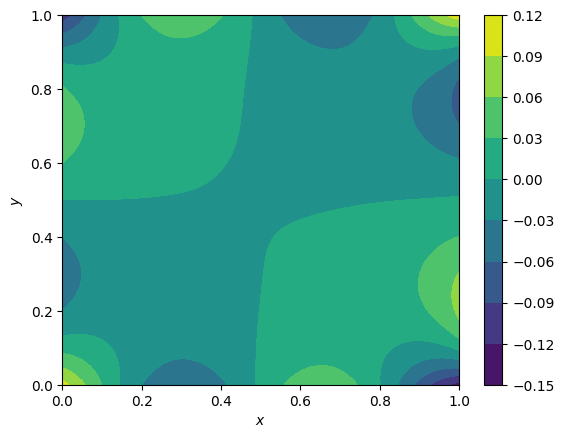

In [ ]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x,y)
z = np.stack([X.flatten(), Y.flatten()], 1)
u_pred = model.predict(z).reshape(100,100)
u_true = np.sin(2*np.pi*X)*np.sin(4*np.pi*Y)
plt.contourf(X, Y,  u_pred - u_true)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("difference u_pred - u_true")
plt.show()

## Helmholtz equation

Consider the Dirichlet problem $$\nabla^2 E(x,y) + \frac{\pi^2}{2}E(x,y) = 0,\qquad x,y \in \Omega =[-2, 2]^2,$$
subject to boundary conditions
$$E(-2,y)=E(2,y)=-\cos\left(\frac{\pi}{2} y\right)-\sin\left(\frac{\pi}{2} y\right),$$
$$E(x,-2)=E(x, 2)=-\cos\left(\frac{\pi}{2} x\right)-\sin\left(\frac{\pi}{2} x\right).$$

We want to find the following solution using a neural network $$ E^*(x,y) = \cos\frac{\pi\left(x- y\right)}{2}+ \sin\frac{\pi\left(x + y\right)}{2}.$$
There are many other solutions to the Dirichlet problem above, for example $(x,y)\mapsto \sin\left(\frac{\pi}{2} x\right)\sin\left(\frac{\pi}{2} y\right)$ is a solution. So to learn $E^*$ we need to provide the neural network with additional training points.

Use the function `helm_data` defined below to generate training points to use with your model. See the [example](https://deepxde.readthedocs.io/en/latest/demos/pinn_inverse/lorenz.inverse.html) to learn how to add training points to your model. Try with 10 points and fewer.

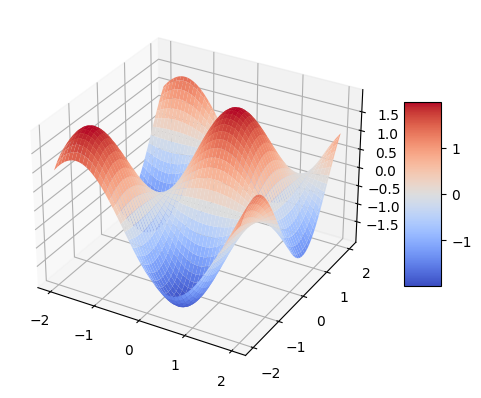

In [ ]:
def helm_sol(X, Y):
    return np.cos((X-Y)*np.pi/2)+np.sin((X+Y)*np.pi/2)

x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = helm_sol(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap="coolwarm")
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
def helm_data(num_pts=10):
    X = np.random.uniform(-2, 2, num_pts)
    Y = np.random.uniform(-2, 2, num_pts)
    Z = np.stack([X, Y], 1)
    return Z, helm_sol(X, Y).reshape(num_pts, 1)

In [ ]:
def Helm_pde(z, u):
    # z = (x, y)
    du_xx = dde.grad.hessian(u, z, i=0, j=0)
    du_yy = dde.grad.hessian(u, z, i=1, j=1)
    return du_xx + du_yy + np.pi ** 2 * u / 2

geom = dde.geometry.Rectangle([-2, -2], [2, 2])

def boundary_lr(X, _):
    return dde.utils.isclose(X[0], -2.0) or dde.utils.isclose(X[0], 2.0)

def boundary_tb(X, _):
    return dde.utils.isclose(X[1], -2.0) or dde.utils.isclose(X[1], 2.0)

def func_lr(z):
    return -np.cos(np.pi*z[:,1:2]/2)-np.sin(np.pi*z[:,1:2]/2)
def func_tb(z):
    return -np.cos(np.pi*z[:,0:1]/2)-np.sin(np.pi*z[:,0:1]/2)


bc1 = dde.icbc.DirichletBC(geom, func_lr, boundary_lr)
bc2 = dde.icbc.DirichletBC(geom, func_tb, boundary_tb)

ob_z, ob_u = helm_data(2)
bc3 = dde.icbc.PointSetBC(ob_z, ob_u)

data = dde.data.PDE(
    geom,
    Helm_pde,
    [bc1, bc2, bc3],
    num_domain=500,
    num_boundary=200,
    anchors=ob_z,
)

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "sin", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(iterations=6000)

Compiling model...
'compile' took 1.649025 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
8000      [4.80e-05, 5.51e-06, 5.13e-06, 3.73e-07]    [4.80e-05, 5.51e-06, 5.13e-06, 3.73e-07]    []  
9000      [4.03e-05, 4.13e-06, 4.03e-06, 5.25e-08]    [4.03e-05, 4.13e-06, 4.03e-06, 5.25e-08]    []  
10000     [3.56e-05, 3.31e-06, 3.25e-06, 8.69e-08]    [3.56e-05, 3.31e-06, 3.25e-06, 8.69e-08]    []  
11000     [2.92e-05, 2.22e-06, 2.59e-06, 5.97e-08]    [2.92e-05, 2.22e-06, 2.59e-06, 5.97e-08]    []  
12000     [3.63e-05, 2.68e-06, 3.21e-06, 1.26e-07]    [3.63e-05, 2.68e-06, 3.21e-06, 1.26e-07]    []  
13000     [2.43e-05, 1.39e-06, 2.19e-06, 1.85e-07]    [2.43e-05, 1.39e-06, 2.19e-06, 1.85e-07]    []  
14000     [2.93e-05, 1.76e-06, 2.63e-06, 5.24e-07]    [2.93e-05, 1.76e-06, 2.63e-06, 5.24e-07]    []  

Best model at step 13000:
  train loss: 2.81e-05
  test loss: 2.81e-05
  test metric: []

'train' took 

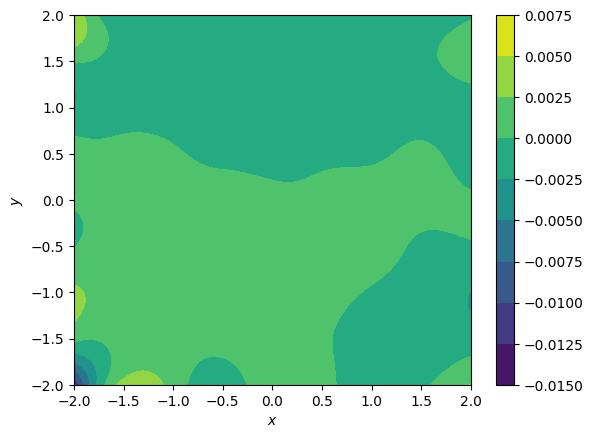

In [ ]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x,y)
z = np.stack([X.flatten(), Y.flatten()], 1)
u_pred = model.predict(z).reshape(100,100)
u_true = helm_sol(X, Y)
plt.contourf(X, Y,  u_pred - u_true)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.show()

## Hamilton-Jacobi equation



\begin{array}{l}\varphi_t+\sin(x)\varphi_x = 0, \;  x\in[0, 2\pi], \; t\in[0, 1], \\ \varphi(x, 0) = \sin(x), \\ \varphi(0, t) = \varphi(2\pi, t)= 0.  \end{array}

The exact solution is
$$
\varphi(x,t) = \sin\left(2\arctan\left(e^{-t}\tan\left(\frac{x}{2} \right)\right)\right)
$$

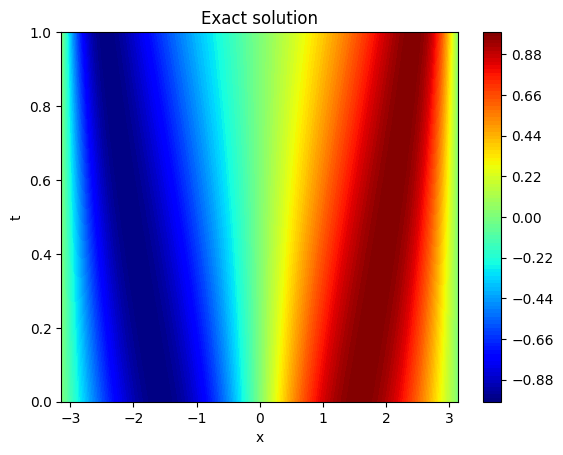

In [ ]:
t_max = 1
x = np.linspace(-np.pi, np.pi, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
phi = np.sin(2*np.arctan(np.exp(-T)*np.tan(X/2)))
plt.contourf(X, T, phi, cmap='jet', levels=100)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact solution')
plt.colorbar()
plt.show()

In [ ]:
def hjb1(z, u):
    x = z[:,0:1]
    u_t = dde.grad.jacobian(u, z, i=0, j=1)
    u_x = dde.grad.jacobian(u, z, i=0, j=0)
    return u_t + tf.sin(x)*u_x


geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(z, _):
    return dde.utils.isclose(z[0], -np.pi) or dde.utils.isclose(z[0], np.pi)

bc = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda z: np.sin(z[:, 0:1]),
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    hjb1,
    [bc, ic],
    num_domain=400,
    num_boundary=100,
    num_initial=50,
)
net = dde.nn.FNN([2] + [64] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(iterations=5000)

Compiling model...
'compile' took 1.166870 s

Training model...

Step      Train loss                        Test loss                         Test metric
5000      [1.03e-04, 2.72e-04, 1.67e-04]    [1.03e-04, 2.72e-04, 1.67e-04]    []  
6000      [3.19e-05, 4.04e-07, 6.38e-06]    [3.19e-05, 4.04e-07, 6.38e-06]    []  
7000      [1.97e-05, 1.10e-07, 3.30e-06]    [1.97e-05, 1.10e-07, 3.30e-06]    []  
8000      [1.27e-05, 3.77e-07, 1.70e-06]    [1.27e-05, 3.77e-07, 1.70e-06]    []  
9000      [8.98e-06, 1.30e-07, 1.28e-06]    [8.98e-06, 1.30e-07, 1.28e-06]    []  
10000     [6.80e-06, 1.06e-07, 1.07e-06]    [6.80e-06, 1.06e-07, 1.07e-06]    []  

Best model at step 10000:
  train loss: 7.98e-06
  test loss: 7.98e-06
  test metric: []

'train' took 14.231454 s



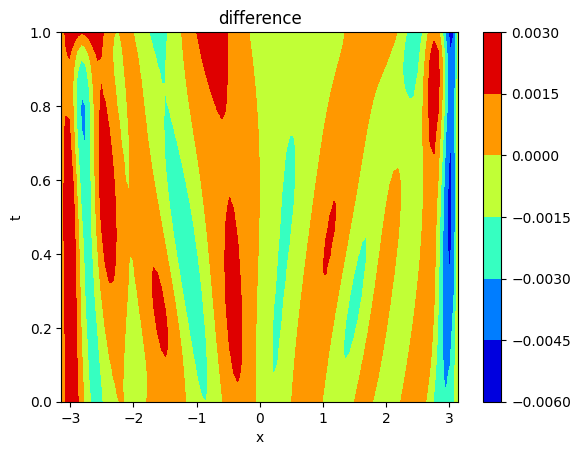

In [ ]:
t_max = 1
x = np.linspace(-np.pi, np.pi, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
u_true = np.sin(2*np.arctan(np.exp(-T)*np.tan(X/2)))
u_pred = model.predict(np.stack([X.flatten(), T.flatten()], 1)).reshape(100, 100)
plt.contourf(X, T, u_pred-u_true, cmap='jet')
plt.xlabel('x')
plt.ylabel('t')
plt.title('difference')
plt.colorbar()
plt.show()

Try with an interval that contains $\pi$, $[0,2\pi]$ for example. What do you see?

\begin{array}{l}\varphi_t+\mathrm{sign}(\cos(x))\varphi_x = 0, \;  x\in[0, 2\pi], \; t\in[0, 1], \\ \varphi(x, 0) = \sin(x), \\ \varphi(0, t) = \varphi(2\pi, t).  \end{array}

If $0\leq t \leq \frac{\pi}{2}$:
$$\varphi(x,t)=\begin{cases}\sin(x-t)  & \text{if}\quad 0\leq x \leq  \frac{\pi}{2} \\
\sin(x+t) & \text{if} \quad\frac{\pi}{2} <  x \leq \frac{3\pi}{2} -t \\
-1 & \text{if} \quad\frac{3\pi}{2} - t<  x \leq \frac{3\pi}{2} +t\\
\sin(x-t) & \text{if}\quad \frac{3\pi}{2} + t<  x \leq 2\pi.
\end{cases}$$


In [ ]:
def sol(x,t):
  if x <= np.pi/2:
    return np.sin(x-t)
  elif x <= 3*np.pi/2 - t:
    return np.sin(x+t)
  elif x <= 3*np.pi/2 + t:
    return -1
  else:
    return np.sin(x-t)

In [ ]:
def hjb2(z, u):
    x = z[:,0:1]
    u_t = dde.grad.jacobian(u, z, i=0, j=1)
    u_x = dde.grad.jacobian(u, z, i=0, j=0)

    return u_t + tf.cos(x)*u_x

geom = dde.geometry.Interval(-np.pi/2, np.pi/2)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(z, _):
    return dde.utils.isclose(z[0], -np.pi) or dde.utils.isclose(z[0], np.pi)

bc = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda z: np.sin(z[:, 0:1]),
    lambda _, on_initial: on_initial,
)

data = dde.data.TimePDE(
    geomtime,
    hjb2,
    [bc, ic],
    num_domain=128,
    num_boundary=32,
    num_initial=16,
)
net = dde.nn.FNN([2] + [128] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

## Kirchhoff plate bending equation

For a thin rectangular plate of thickness $H$, Young's modulus  $E$, and Poisson's ratio $\nu$, we can define parameters in terms of the plate deflection, $w$.

The flexural rigidity is given by
$$
D = \frac{EH^3}{12(1-\nu^2)}.
$$

The bending moments per unit length are given by
$$
M_x = - D\left(\frac{\partial^2 w}{\partial x^2} +\nu \frac{\partial^2 w}{\partial y^2}\right),
$$
$$
M_y = - D\left(\nu \frac{\partial^2 w}{\partial x^2} +\frac{\partial^2 w}{\partial y^2}\right).
$$
The twisting moment per unit length is given by

$$
M_{xy} = -D(1-\nu)\frac{\partial^2 w}{\partial x \partial y}.
$$

We want to solve the [Kirchnoff equation](https://en.wikipedia.org/wiki/Kirchhoff%E2%80%93Love_plate_theory)
$$ \Delta^2 w = \frac{q}{D},$$
with sinusoidal load
$$ q(x,y) = q_0 \sin \frac{\pi x}{a}\sin\frac{\pi y}{b},$$
where $q_0, a$ and $b$ are constants. We impose the following boundary conditions: $M=0$ at the boundary, the bending moment $M_{xx}$ is zero at $x=0$ and $x=a$, and $M_{yy}$ is zero at $y=0$ and $y=b$.

With these conditions, the exact solution is
$$ w(x,y) = \frac{q_0}{\pi^4 D}\left(\frac{1}{a^2} + \frac{1}{b^2} \right)^{-2}\sin \frac{\pi x}{a}\sin\frac{\pi y}{b}.$$

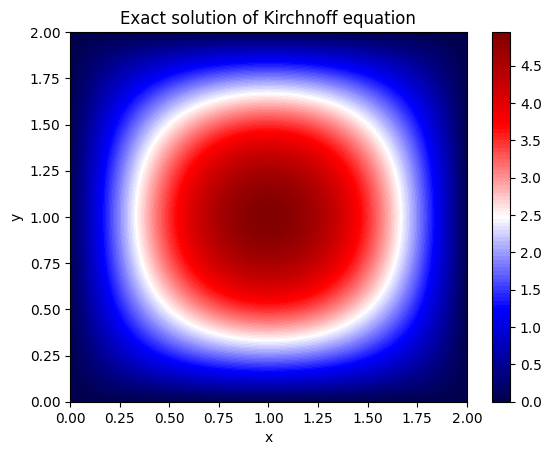

In [ ]:
a = 2.
b = 2.
D = 1/12.
q0 = 10.
r = q0*((a**2 * b**2) / (a**2 + b**2))**2 / (np.pi**4 * D)

def w_solution(X, Y):
    return r*np.sin(np.pi * X / a)*np.sin(np.pi * Y / b)

x = np.linspace(0, a, 100)
y = np.linspace(0, b, 100)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, w_solution(X, Y), cmap='seismic', levels=100)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact solution of Kirchnoff equation')
plt.colorbar()
plt.show()

In [ ]:
def kirchhoff(z, u):
    # z = (x, y)
    u_xx = dde.grad.hessian(u, z, i=0, j=0)
    u_yy = dde.grad.hessian(u, z, i=1, j=1)
    u_xxxx = dde.grad.hessian(u_xx, z, i=0, j=0)
    u_yyxx = dde.grad.hessian(u_yy, z, i=0, j=0)
    u_yyyy = dde.grad.hessian(u_yy, z, i=1, j=1)
    q = q0 * tf.sin(np.pi*z[:,0:1] / a)*tf.sin(np.pi*z[:,1:2] / b)
    return u_xxxx + 2*u_yyxx + u_yyyy - q/D

geom = dde.geometry.Rectangle([0, 0], [a, b])

def boundary_lr(z, _):
    return dde.utils.isclose(z[0], 0.0) or dde.utils.isclose(z[0], a)
def boundary_tb(z, _):
    return dde.utils.isclose(z[1], 0.0) or dde.utils.isclose(z[1], b)

def momemt_bc1(z, u, _):
    return dde.grad.hessian(u, z, i=0, j=0)
def momemt_bc2(z, u, _):
    return dde.grad.hessian(u, z, i=1, j=1)

bc1 = dde.icbc.DirichletBC(geom, lambda z: 0.0, boundary_lr)
bc2 = dde.icbc.DirichletBC(geom, lambda z: 0.0, boundary_tb)
bc3 = dde.icbc.OperatorBC(geom, momemt_bc1, boundary_lr)
bc4 = dde.icbc.OperatorBC(geom, momemt_bc2, boundary_tb)

data = dde.data.PDE(
    geom,
    kirchhoff,
    [bc1, bc2, bc3, bc4],
    num_domain=500,
    num_boundary=100,
)

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 6.833116 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
50000     [5.03e-04, 3.55e-05, 2.75e-05, 5.02e-05, 1.23e-04]    [5.03e-04, 3.55e-05, 2.75e-05, 5.02e-05, 1.23e-04]    []  
51000     [4.36e-04, 3.43e-05, 2.70e-05, 4.92e-05, 1.22e-04]    [4.36e-04, 3.43e-05, 2.70e-05, 4.92e-05, 1.22e-04]    []  
52000     [6.11e-04, 3.37e-05, 2.67e-05, 4.88e-05, 1.21e-04]    [6.11e-04, 3.37e-05, 2.67e-05, 4.88e-05, 1.21e-04]    []  
53000     [4.16e-04, 3.17e-05, 2.54e-05, 4.78e-05, 1.18e-04]    [4.16e-04, 3.17e-05, 2.54e-05, 4.78e-05, 1.18e-04]    []  
54000     [4.00e-04, 3.04e-05, 2.46e-05, 4.71e-05, 1.16e-04]    [4.00e-04, 3.04e-05, 2.46e-05, 4.71e-05, 1.16e-04]    []  
55000     [3.90e-04, 2.92e-05, 2.39e-05, 4.63e-05, 1.14e-04]    [3.90e-04, 2.92e-05, 2.39e-05, 4.63e-05, 1.14e-04]    []  
56000     [5.94e-04, 2.77e-05, 2.33e-05, 4.51e-05, 1.12e-04]    [5.

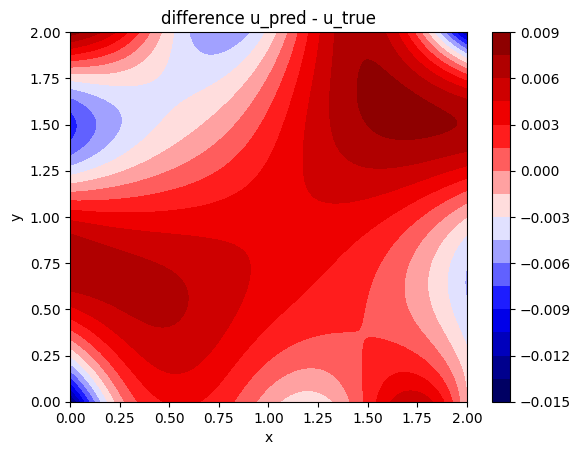

In [ ]:
x = np.linspace(0, a, 100)
y = np.linspace(0, b, 100)
X, Y = np.meshgrid(x, y)
u_pred = model.predict(np.stack([X.flatten(), Y.flatten()], 1)).reshape(100, 100)
plt.contourf(X, Y, u_pred - w_solution(X, Y), cmap='seismic', levels=20)
plt.xlabel('x')
plt.ylabel('y')
plt.title("difference u_pred - u_true")
plt.colorbar()
plt.show()

## Klein-Gordon equation

### Example 1

Let $a \in \mathbb{R}$ and $b>0$. Give an approximation to the solution of the equation $$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [1, 5]\times [0,T], $$
with initial conditions $$ \psi(x,0) = a \cos\left(\frac{\pi}{2} x \right) \quad\text{and}\quad \psi_t(x,0)=b\mu\cos\left(\frac{\pi}{2}x\right),$$
and Dirichlet boundary conditions $$ \psi(1,t) = \psi(5,t) = 0,$$

where $$\mu = \sqrt{b +\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t) = \cos\left(\frac{\pi x}{2}\right) \left(a \cos\left(\mu t \right) + b\sin\left(\mu t\right)\right).$$

Take:

In [ ]:
a = 2
b = 3
mu = np.sqrt(b + a**2 * np.pi**2 / 4)
t_max = 2
x_min = 1
x_max = 5

We plot the exact solution:

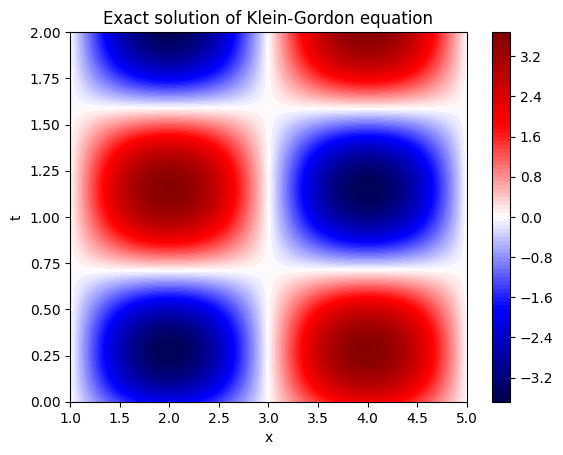

In [ ]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
psi = np.cos(X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T))
plt.contourf(X, T, psi, cmap='seismic', levels=100)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact solution of Klein-Gordon equation')
plt.colorbar()
plt.show()

In [ ]:
def klein_gordon1(z, u):
    # z = (x, t)
    u_xx = dde.grad.hessian(u, z, i=0, j=0)
    u_tt = dde.grad.hessian(u, z, i=1, j=1)
    return u_tt - a**2 * u_xx + b * u

geom = dde.geometry.Interval(x_min, x_max)
timedomain = dde.geometry.TimeDomain(0.0, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_ic1(z, on_boundary):
    return on_boundary

def boundary_ic2(z, on_boundary):
    return dde.utils.isclose(z[1], 0.0)

def boundary_bc(z, _):
    return dde.utils.isclose(z[0], x_min) or dde.utils.isclose(z[0], x_max)

def func_ic(z, u, _):
    return dde.grad.jacobian(u, z, i=0, j=1) - b * mu * tf.cos(np.pi * z[:, 0:1] / 2)

ic1 = dde.icbc.IC(geomtime, lambda z: a * tf.cos(np.pi * z[:, 0:1] / 2), boundary_ic1)
ic2 = dde.icbc.OperatorBC(geomtime, func_ic, boundary_ic2)
bc = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_bc)

data = dde.data.TimePDE(
    geomtime,
    klein_gordon1,
    [ic1, ic2, bc],
    num_domain=500,
    num_boundary=16,
    num_initial=16,
)

net = dde.nn.FNN(
    [2] + [50] * 4 + [1], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=15000, display_every=2500)

Compiling model...
Building feed-forward neural network...
'build' took 0.186803 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.577664 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.12e-02, 2.10e+00, 5.84e+01, 1.06e-02]    [7.12e-02, 2.10e+00, 5.84e+01, 1.06e-02]    []  
2500      [2.33e-01, 2.15e-01, 4.33e-02, 6.92e-01]    [2.33e-01, 2.15e-01, 4.33e-02, 6.92e-01]    []  
5000      [2.14e-02, 1.89e-02, 5.64e-04, 8.57e-02]    [2.14e-02, 1.89e-02, 5.64e-04, 8.57e-02]    []  
7500      [5.26e-03, 5.55e-03, 6.28e-04, 3.72e-02]    [5.26e-03, 5.55e-03, 6.28e-04, 3.72e-02]    []  
10000     [4.68e-03, 1.66e-03, 3.88e-04, 1.43e-02]    [4.68e-03, 1.66e-03, 3.88e-04, 1.43e-02]    []  
12500     [2.21e-03, 5.81e-04, 1.37e-04, 5.47e-03]    [2.21e-03, 5.81e-04, 1.37e-04, 5.47e-03]    []  
15000     [1.62e-03, 2.59e-04, 5.61e-05, 2.66e-03]    [1.62e-03, 2.59e-04, 5.61e-05, 2.66e-03]    []  

Best model at step 15000:
  train loss: 4.59e-03
  test loss: 4.59e-03
  test metric: []

'train' took 28.651355 s



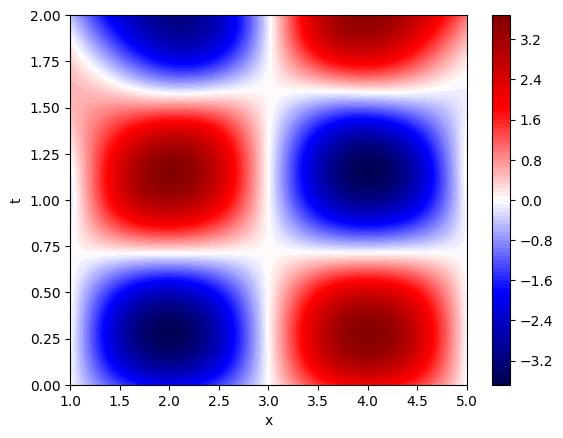

In [ ]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
u_true = np.cos(X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T))
u_pred = model.predict(np.stack([X.flatten(), T.flatten()], 1)).reshape(100, 100)
plt.contourf(X, T, u_pred, cmap='seismic', levels=100)
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

### Example 2

Let $a \in \mathbb{R}$ and $b>0$. Give an approximation to the solution of the equation $$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [0, 4]\times [0,T], $$

with initial conditions $$ \psi(x,0) = ae^{-\frac{\pi x}{2}} \quad \text{and}\quad \psi_t(x,0)=b\mu e^{-\frac{\pi}{2}x}$$
and boundary conditions
$$\psi(0, t) = a\cos(\mu t) + b\sin(\mu t)\qquad \text{and}\qquad
 \psi(4,t) = e^{-2\pi}\left(a\cos(\mu t) + b\sin(\mu t)\right)$$

where $$\mu = \sqrt{b -\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t)=e^{-\frac{\pi}{2} x}\left( a\cos(\mu t)+b\sin(\mu t)\right).$$

Take:

In [ ]:
# make sure that b>a^2*pi*2/4 when choosing the parameters
a = 1
b = 3
mu = np.sqrt(b - a**2 * np.pi**2 / 4)
t_max = 12
x_max = 4

We plot the exact solution:

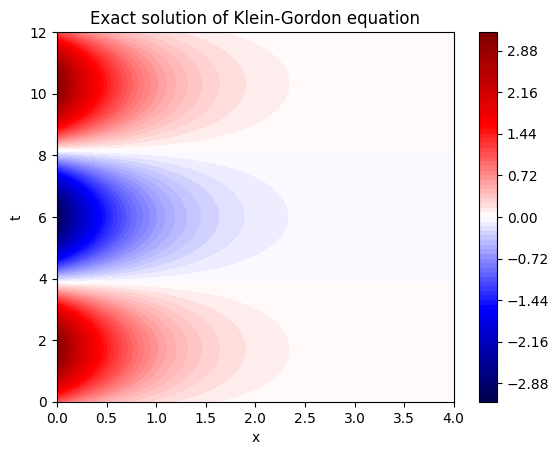

In [ ]:
x = np.linspace(0, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
psi = np.exp(-X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T))
plt.contourf(X, T, psi, cmap='seismic', levels=100)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact solution of Klein-Gordon equation')
plt.colorbar()
plt.show()

In [ ]:
def kg1_sol(z):
    return np.exp(-z[:,:1]*np.pi/2)*(a*np.cos(mu*z[:,1:])+b*np.sin(mu*z[:,1:]))

def klein_gordon2(z, u):
    # z = (x, t)
    u_xx = dde.grad.hessian(u, z, i=0, j=0)
    u_tt = dde.grad.hessian(u, z, i=1, j=1)
    return u_tt - a**2*u_xx + b*u

geom = dde.geometry.Interval(0, x_max)
timedomain = dde.geometry.TimeDomain(0, t_max)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_ic(z, on_boundary):
    return dde.utils.isclose(z[1], 0.0)

def boundary_l(z, _):
    return dde.utils.isclose(z[0], 0.0)

def boundary_r(z, _):
    return dde.utils.isclose(z[0], x_max)

def func_ic(z, u, _):
    return dde.grad.jacobian(u, z, i=0, j=1) - b*mu*tf.exp(-np.pi*z[:,0:1]/2)

def func_bcl(z):
    return a*tf.cos(mu*z[:,1:]) + b*tf.sin(mu*z[:,1:])
def func_bcr(z):
    return tf.exp(-2*np.pi)*(a*tf.cos(mu*z[:,1:]) + b*tf.sin(mu*z[:,1:]))

ic1 = dde.icbc.IC(geomtime, lambda z: a*tf.exp(-np.pi*z[:,0:1]/2), boundary_ic)
ic2 = dde.icbc.OperatorBC(geomtime, func_ic, boundary_ic)
bc1 = dde.icbc.DirichletBC(geomtime, func_bcl, boundary_l)
bc2 = dde.icbc.DirichletBC(geomtime, func_bcr, boundary_r)

data = dde.data.TimePDE(
    geomtime,
    klein_gordon2,
    [ic1, ic2, bc1, bc2],
    num_domain=500,
    num_boundary=150,
    num_initial=150,
)

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000, display_every=2500)

Compiling model...
Building feed-forward neural network...
'build' took 0.197164 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.103517 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [7.39e-01, 8.48e-02, 2.88e-01, 4.82e+00, 2.72e-02]    [7.39e-01, 8.48e-02, 2.88e-01, 4.82e+00, 2.72e-02]    []  
2500      [3.42e-03, 1.99e-05, 4.66e-05, 3.17e-03, 3.27e-05]    [3.42e-03, 1.99e-05, 4.66e-05, 3.17e-03, 3.27e-05]    []  
5000      [3.38e-04, 1.96e-06, 1.63e-06, 1.89e-04, 6.44e-06]    [3.38e-04, 1.96e-06, 1.63e-06, 1.89e-04, 6.44e-06]    []  
7500      [6.83e-03, 3.37e-04, 1.20e-05, 1.40e-03, 4.59e-04]    [6.83e-03, 3.37e-04, 1.20e-05, 1.40e-03, 4.59e-04]    []  
10000     [2.08e-03, 9.28e-05, 1.37e-05, 2.08e-03, 1.52e-04]    [2.08e-03, 9.28e-05, 1.37e-05, 2.08e-03, 1.52e-04]    []  

Best model at step 5000:
  train loss: 5.37e-04
  test loss: 5.37e-04
  test metric: []

'train' took 24.893074 s



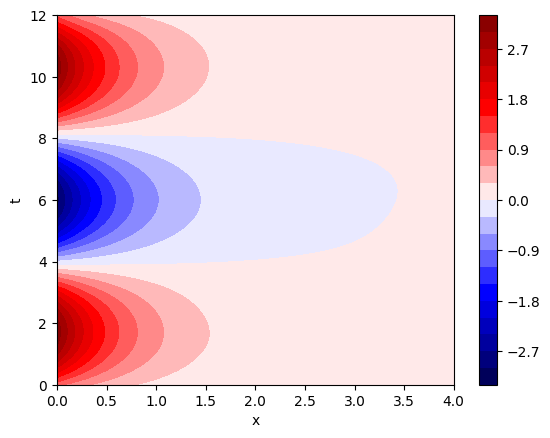

In [ ]:
x = np.linspace(0, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)
u_true = np.exp(-X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T))
u_pred = model.predict(np.stack([X.flatten(), T.flatten()], 1)).reshape(100, 100)
plt.contourf(X, T, u_pred, cmap='seismic', levels=20)
plt.xlabel('x')
plt.ylabel('t')
plt.colorbar()
plt.show()

## Schrödinger equation

In this example you will need to find the eigenstates of the Schrödinger equation of the quantum harmonic oscillator $$-\frac{\hbar^2}{2m}\frac{d^2 \psi}{dx^2} + \frac{1}{2}mx^2\omega^2 \psi = E\psi. $$

The eigenvalue $E_n = \omega (n + 1/2)$ has the normalized eigenstate

$$
\psi_n(x) = \frac{\omega^{1/4}}{\pi^{1/4} \sqrt{2^n n!}}  H_n\left(\sqrt{\omega} x\right)e^{-\frac{\omega x^2}{2}}.
$$

We will take $\hbar = m=1$. The initial condition is $(\psi(0), \psi'(0)) =(1,0)$ is $n$ is even and $(0,1)$ if $n$ is odd.

In [ ]:
n = 5
omega = 0.5
E = (n + 0.5) * omega
coeff = [0]*n + [1]

def psi_sol(x):
    return (
        1 / (2**n * np.math.factorial(n))**0.5
        * (omega / np.pi)**(1/4)
        * np.exp(-omega * x**2 / 2)
        * hermval(omega**0.5 * x, coeff)
    )

In [ ]:
def schrodinger(t, y):
    y_tt = dde.grad.hessian(y, t)
    return -y_tt / 2 + t**2 * omega**2 * y / 2 - E*y

geom = dde.geometry.TimeDomain(-10, 10)

def boundary_l(t, on_initial):
    return dde.utils.isclose(t[0], 0.0)

def bc_func(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - 1


ic1 = dde.icbc.IC(geom, lambda x: 0, lambda _, on_initial: on_initial)
ic2 = dde.icbc.OperatorBC(geom, bc_func, boundary_l)

data = dde.data.TimePDE(geom, schrodinger, [ic1, ic2], num_domain=500, num_boundary=20)
net = dde.nn.FNN([1] + [50] * 4 + [1], "sin", "Glorot uniform")
model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-6)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 0.819696 s

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [4.31e-06, 6.63e-08, 2.26e-10]    [4.31e-06, 6.63e-08, 2.26e-10]    []  
11000     [3.60e-06, 2.18e-08, 5.29e-11]    [3.60e-06, 2.18e-08, 5.29e-11]    []  
12000     [3.07e-06, 6.33e-09, 6.00e-11]    [3.07e-06, 6.33e-09, 6.00e-11]    []  
13000     [2.74e-06, 1.60e-09, 3.41e-11]    [2.74e-06, 1.60e-09, 3.41e-11]    []  
14000     [2.51e-06, 6.99e-10, 5.03e-11]    [2.51e-06, 6.99e-10, 5.03e-11]    []  
15000     [2.33e-06, 1.54e-09, 5.20e-11]    [2.33e-06, 1.54e-09, 5.20e-11]    []  
16000     [2.19e-06, 1.54e-09, 4.30e-11]    [2.19e-06, 1.54e-09, 4.30e-11]    []  
17000     [2.06e-06, 2.41e-09, 4.78e-11]    [2.06e-06, 2.41e-09, 4.78e-11]    []  
18000     [1.95e-06, 1.77e-09, 1.64e-11]    [1.95e-06, 1.77e-09, 1.64e-11]    []  
19000     [1.85e-06, 2.73e-09, 3.77e-11]    [1.85e-06, 2.73e-09, 3.77e-11]    []  
20000     [1.76

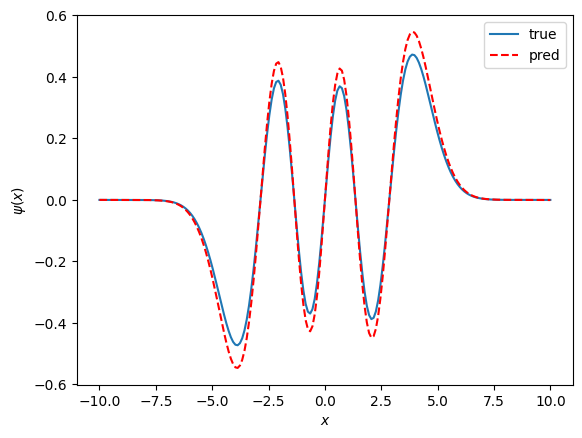

In [ ]:
x = np.linspace(-10, 10, 200)

plt.plot(x, psi_sol(x),label="true")
plt.plot(x, model.predict(x.reshape(200,1)),"r--", label="pred")
plt.xlabel("$x$")
plt.ylabel("$\psi(x)$")
plt.legend()
plt.show()

## Taylor-Green vortex flow

The 2-D Navier-Stokes equations of the Taylor-Green vortex flow are
$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0,
$$

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right), $$


$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right), $$

for $x,y\in[0,2\pi]$ and $t\in[0,10]$. The exact solution is given by

\begin{array}{l}
u(x,y,t)=\sin x\cos y\exp(-2\nu t),\\
v(x,y,t)=-\cos x\sin y\exp(-2\nu t),\\
p(x,y,t) ={\frac  {\rho }{4}}\left(\cos 2x+\cos 2y\right)\exp(-4\nu t).
\end{array}

1. Give an approximation to the solution using initial conditions and Dirichlet boundary. Use the exact solution to set the appropriate conditions.
2. Repeat 1) but, this time, using initial conditions, Dirichlet BCs for $u$ and $v$, and  Neumann boundary conditions for $p$. We give the gradient of $p$:
$$\nabla p = -\frac{\rho}{2}\exp\left(-4\nu t\right)\left(\sin(2x), \sin(2y)\right).$$

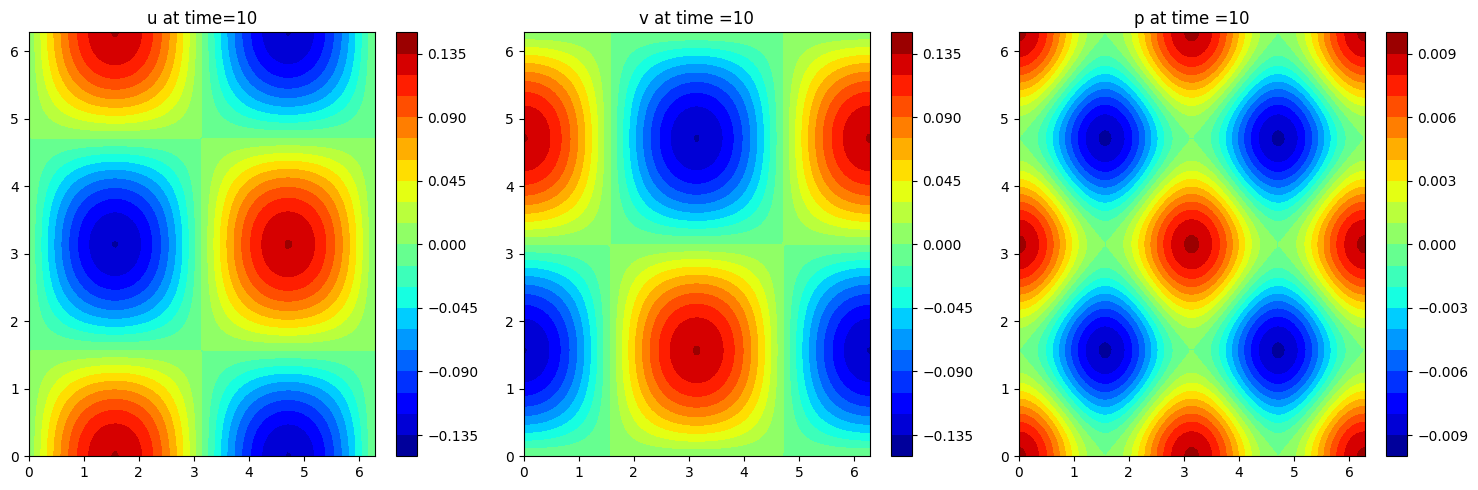

In [ ]:
rho = 1
nu = 0.1

def tgv_flow(x, y, t):
    u = np.sin(x)*np.cos(y)*np.exp(-2*nu*t)
    v=-np.cos(x)*np.sin(y)*np.exp(-2*nu*t)
    p =rho*(np.cos(2*x)+np.cos(2*y))*np.exp(-4*nu*t)/4
    return u, v, p

# set the time
t = 10
# the temporal grid
x = np.linspace(0, 2*np.pi, 100)
y = np.linspace(0, 2*np.pi, 100)
X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# plot u
fig.colorbar(axs[0].contourf(X, Y, tgv_flow(X, Y, t)[0], cmap="jet", levels=20))
axs[0].set_title("u at time={}".format(t))

# plot v
fig.colorbar(axs[1].contourf(X, Y, tgv_flow(X, Y, t)[1], cmap="jet", levels=20))
axs[1].set_title("v at time ={}".format(t))

# plot p
fig.colorbar(axs[2].contourf(X, Y, tgv_flow(X, Y, t)[2], cmap="jet", levels=20))
axs[2].set_title("p at time ={}".format(t))

plt.tight_layout()
plt.show()

1. With Dirichlet boundary conditions only:

In [ ]:
def tgv_pde(z, f):
    # z = (x, y, t)
    # f = (u, v, p)
    u, v, p = f[:,:1], f[:,1:2], f[:,2:]
    u_t = dde.grad.jacobian(f, z, i=0, j=2)
    v_t = dde.grad.jacobian(f, z, i=1, j=2)
    u_x = dde.grad.jacobian(f, z, i=0, j=0)
    u_y = dde.grad.jacobian(f, z, i=0, j=1)
    v_x = dde.grad.jacobian(f, z, i=1, j=0)
    v_y = dde.grad.jacobian(f, z, i=1, j=1)
    u_xx = dde.grad.hessian(f, z, i=0, j=0, component=0)
    u_yy = dde.grad.hessian(f, z, i=1, j=1, component=0)
    v_xx = dde.grad.hessian(f, z, i=0, j=0, component=1)
    v_yy = dde.grad.hessian(f, z, i=1, j=1, component=1)
    p_x = dde.grad.jacobian(f, z, i=2, j=0)
    p_y = dde.grad.jacobian(f, z, i=2, j=1)

    res1 = u_x + v_y
    res2 = u_t + u*u_x + v*u_y + p_x/rho - nu*(u_xx + u_yy)
    res3 = v_t + u*v_x + v*v_y + p_y/rho - nu*(v_xx + v_yy)
    return res1, res2, res3

geom = dde.geometry.Rectangle([0, 0], [2*np.pi, 2*np.pi])
timedomain = dde.geometry.TimeDomain(0.0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_ic(z, on_boundary):
    return on_boundary

def boundary_lr(z, _):
    return dde.utils.isclose(z[0], 0.0) or dde.utils.isclose(z[0], 2*np.pi)

def boundary_tb(z, _):
    return dde.utils.isclose(z[1], 0.0) or dde.utils.isclose(z[1], 2*np.pi)

# ICs
ic1 = dde.icbc.IC(
    geomtime, lambda z: tf.sin(z[:,0:1])*tf.cos(z[:,1:2]),
    boundary_ic, component=0)
ic2 = dde.icbc.IC(
    geomtime, lambda z: -tf.cos(z[:,0:1])*tf.sin(z[:,1:2]),
    boundary_ic, component=1)
ic3 = dde.icbc.IC(
    geomtime, lambda z: (tf.cos(2*z[:,0:1]) + tf.cos(2*z[:,1:2]))*rho/4,
    boundary_ic, component=2)
#=========================
# left and right borders
#========================
bc1 = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_lr, component=0)
bc2 = dde.icbc.DirichletBC(
    geomtime, lambda z: -tf.sin(z[:,1:2])*tf.exp(-2*nu*z[:,2:]),
    boundary_lr, component=1)
bc3 = dde.icbc.DirichletBC(
    geomtime, lambda z: rho*(1 + tf.cos(z[:,1:2]))*tf.exp(-4*nu*z[:,2:])/4,
    boundary_lr, component=2)
#=========================
# top and bottom borders
#========================
bc4 = dde.icbc.DirichletBC(
    geomtime, lambda z: tf.sin(z[:,0:1])*tf.exp(-2*nu*z[:,2:]),
    boundary_tb, component=0)
bc5 = dde.icbc.DirichletBC(
    geomtime, lambda z: 0.0,
    boundary_tb, component=1)
bc6 = dde.icbc.DirichletBC(
    geomtime, lambda z: rho*(1 + tf.cos(z[:,0:1]))*tf.exp(-4*nu*z[:,2:])/4,
    boundary_tb, component=2)

data = dde.data.TimePDE(
    geomtime,
    tgv_pde,
    [ic1, ic2, ic3, bc1, bc2, bc3, bc4, bc5, bc6],
    num_domain=1000,
    num_boundary=500,
    num_initial=200,
)

net = dde.nn.FNN(
    [3] + [128] * 4 + [3], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=4000)

Compiling model...
'compile' took 5.309736 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
4000      [2.49e-03, 5.43e-03, 3.18e-03, 2.83e-03, 2.55e-03, 2.65e-03, 8.26e-04, 9.48e-04, 2.83e-03, 9.04e-04, 1.08e-03, 1.49e-03]    [2.49e-03, 5.43e-03, 3.18e-03, 2.83e-03, 2.55e-03, 2.65e-03, 8.26e-04, 9.48e-04, 2.83e-03, 9.04e-04, 1.08e-03, 1.49e-03]    []  
5000      [1.74e-03, 4.11e-03, 2.36e-03, 1.58e-03, 1.46e-03, 1.58e-03, 5.32e-04, 6.13e-04, 2.73e-03, 5.95e-04, 6.14e-04, 1.49e-03]    [1.74e-03, 4.11e-03, 2.36e-03, 1.58e-03, 1.46e-03, 1.58e-03, 5.32e-04, 6.13e-04, 2.73e-03, 5.95e-04, 6.14e-04, 1.49e-03]    []  
6000      [9.14e-04, 2.44e-03, 1.54e-03, 6.70e-04, 6.59e-04, 8.57e-04, 2.50e-04, 3.30e-04, 2.55e-03, 3.08e-04, 2.94e-04, 1.44e-03]    [9.14

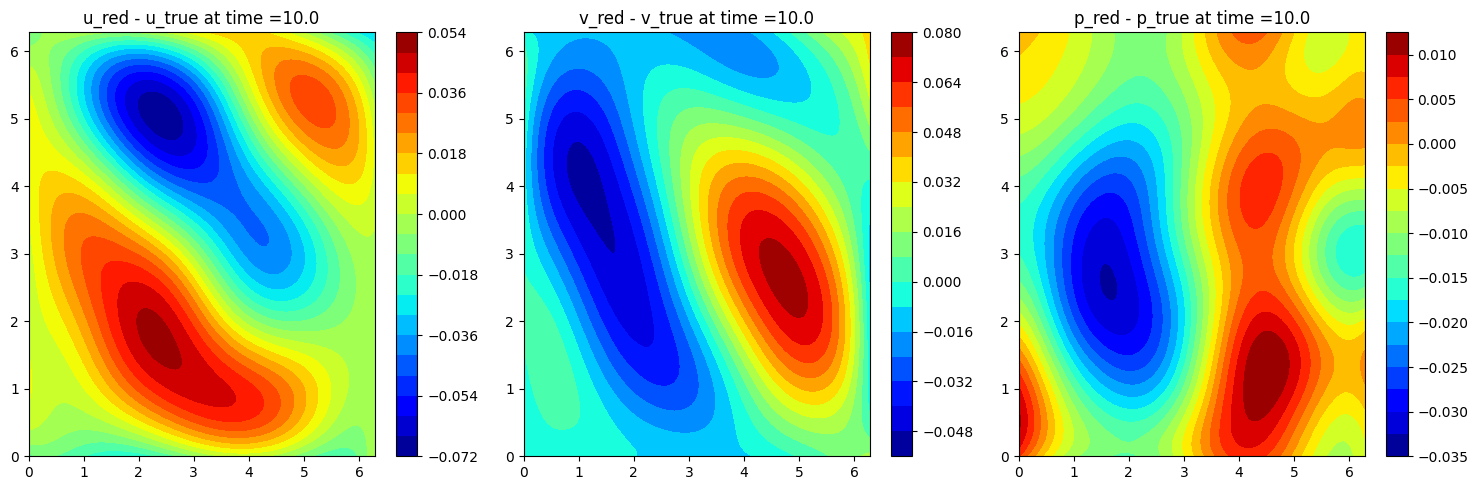

In [ ]:
# choose the time
t = 10.
# create a grid
x = np.linspace(0, 2*np.pi, 100)
y = np.linspace(0, 2*np.pi, 100)
X, Y = np.meshgrid(x, y)
# compute the prediction on the grid
Z = model.predict(np.stack([X.flatten(), Y.flatten(), [t]*10000], 1))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
# plot u
fig.colorbar(axs[0].contourf(X, Y, Z[:,0:1].reshape(100, 100) - tgv_flow(X, Y, t)[0], cmap="jet", levels=20))
axs[0].set_title("u_red - u_true at time ={}".format(t))

# plot v
fig.colorbar(axs[1].contourf(X, Y, Z[:,1:2].reshape(100, 100) - tgv_flow(X, Y, t)[1], cmap="jet", levels=20))
axs[1].set_title("v_red - v_true at time ={}".format(t))

# plot p
fig.colorbar(axs[2].contourf(X, Y, Z[:,2:].reshape(100, 100) - tgv_flow(X, Y, t)[2], cmap="jet", levels=20))
axs[2].set_title("p_red - p_true at time ={}".format(t))

plt.tight_layout()
plt.show()

2. With a mix of Dirichlet and Neumann boundary conditions:

In [ ]:
def tgv_pde(z, f):
    # z = (x, y, t)
    # f = (u, v, p)
    u, v, p = f[:,:1], f[:,1:2], f[:,2:]
    u_t = dde.grad.jacobian(f, z, i=0, j=2)
    v_t = dde.grad.jacobian(f, z, i=1, j=2)
    u_x = dde.grad.jacobian(f, z, i=0, j=0)
    u_y = dde.grad.jacobian(f, z, i=0, j=1)
    v_x = dde.grad.jacobian(f, z, i=1, j=0)
    v_y = dde.grad.jacobian(f, z, i=1, j=1)
    u_xx = dde.grad.hessian(f, z, i=0, j=0, component=0)
    u_yy = dde.grad.hessian(f, z, i=1, j=1, component=0)
    v_xx = dde.grad.hessian(f, z, i=0, j=0, component=1)
    v_yy = dde.grad.hessian(f, z, i=1, j=1, component=1)
    p_x = dde.grad.jacobian(f, z, i=2, j=0)
    p_y = dde.grad.jacobian(f, z, i=2, j=1)

    res1 = u_x + v_y
    res2 = u_t + u*u_x + v*u_y + p_x/rho - nu*(u_xx + u_yy)
    res3 = v_t + u*v_x + v*v_y + p_y/rho - nu*(v_xx + v_yy)
    return res1, res2, res3

geom = dde.geometry.Rectangle([0, 0], [2*np.pi, 2*np.pi])
timedomain = dde.geometry.TimeDomain(0.0, 10)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_ic(z, on_boundary):
    return on_boundary

def boundary_lr(z, _):
    return dde.utils.isclose(z[0], 0.0) or dde.utils.isclose(z[0], 2*np.pi)

def boundary_tb(z, _):
    return dde.utils.isclose(z[1], 0.0) or dde.utils.isclose(z[1], 2*np.pi)

# ICs
ic1 = dde.icbc.IC(
    geomtime, lambda z: tf.sin(z[:,0:1])*tf.cos(z[:,1:2]),
    boundary_ic, component=0)
ic2 = dde.icbc.IC(
    geomtime, lambda z: -tf.cos(z[:,0:1])*tf.sin(z[:,1:2]),
    boundary_ic, component=1)
ic3 = dde.icbc.IC(
    geomtime, lambda z: (tf.cos(2*z[:,0:1]) + tf.cos(2*z[:,1:2]))*rho/4,
    boundary_ic, component=2)
#=========================
# Dirichlet left and right borders
#========================
bc1 = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_lr, component=0)
bc2 = dde.icbc.DirichletBC(
    geomtime, lambda z: -tf.sin(z[:,1:2])*tf.exp(-2*nu*z[:,2:]),
    boundary_lr, component=1)
#=========================
# Dirichlet top and bottom borders
#========================
bc3 = dde.icbc.DirichletBC(
    geomtime, lambda z: tf.sin(z[:,0:1])*tf.exp(-2*nu*z[:,2:]),
    boundary_tb, component=0)
bc4 = dde.icbc.DirichletBC(
    geomtime, lambda z: 0.0,
    boundary_tb, component=1)
#===================
# Neumann BCs for p
#===================
bc5 = dde.icbc.NeumannBC(geomtime, lambda z: 0.0, boundary_lr, component=2)
bc6 = dde.icbc.NeumannBC(geomtime, lambda z: 0.0, boundary_tb, component=2)

data = dde.data.TimePDE(
    geomtime,
    tgv_pde,
    [ic1, ic2, ic3, bc1, bc2, bc3, bc4, bc5, bc6],
    num_domain=1000,
    num_boundary=500,
    num_initial=200
    )

net = dde.nn.FNN(
    [3] + [128] * 4 + [3], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-4)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.114630 s

'compile' took 3.222567 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [6.93e-03, 1.84e-02, 3.48e-03, 3.67e-01, 6.27e-01, 1.87e-01, 1.47e-01, 7.65e-01, 2.13e-01, 6.38e-01, 7.02e-03, 5.96e-03]    [6.93e-03, 1.84e-02, 3.48e-03, 3.67e-01, 6.27e-01, 1.87e-01, 1.47e-01, 7.65e-01, 2.13e-01, 6.38e-01, 7.02e-03, 5.96e-03]    []  
1000      [1.18e-02, 4.22e-03, 4.78e-03, 8.16e-02, 8.88e-02, 5.74e-02, 1.03e-02, 2.58e-02, 2.21e-02, 1.24e-02, 4.18e-04, 7.00e-04]    [1.18e-02, 4.22e-03, 4.78e-03, 8.16e-02, 8.88e-02, 5.74e-02, 1.03e-02, 2.58e-02, 2.21e-02, 1.24e-02, 4.18e-04, 7.00e-04]    []  
2000      [9.53e-03, 5.74e-03, 7.63e-03, 3.04e-02, 3.09e-02, 3.92e-02, 4.6

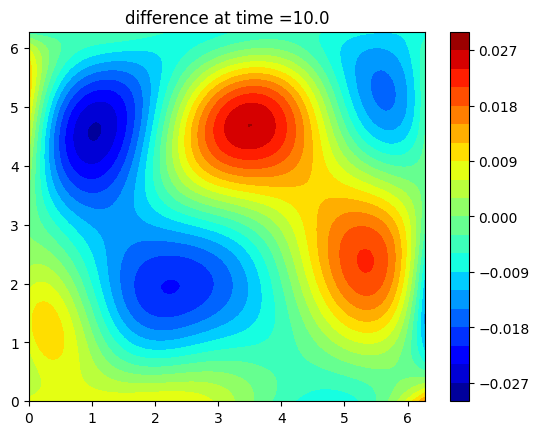

In [ ]:
x = np.linspace(0, 2*np.pi, 100)
y = np.linspace(0, 2*np.pi, 100)
X, Y = np.meshgrid(x, y)
# choose the time
t = 10.
Z = model.predict(np.stack([X.flatten(), Y.flatten(), [t]*10000], 1))
plt.contourf(X, Y, Z[:,1:2].reshape(100, 100) - tgv_flow(X, Y, t)[1], cmap="jet", levels=20)
plt.title("difference at time ={}".format(t))
plt.colorbar()
plt.show()

## Lorenz 96 model

The `Lorenz 96 model` is a dynamical system formulated by Edward Lorenz in 1996. It is defined as follows. For $i = 1, \ldots, N$:
$$ \frac{dx_{i}}{dt}=(x_{i+1}-x_{i-2})x_{i-1}-x_{i}+F$$
where it is assumed that $x_{-1}=x_{N-1},x_{0}=x_{N}$ and $ x_{N+1}=x_{1}$ and
$N\geq 4$. Here $x_{i}$ is the state of the system and $F$ is a constant.

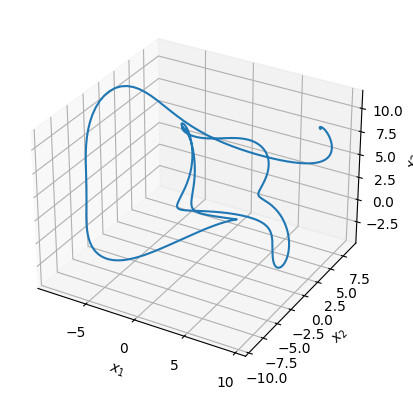

In [29]:
# These are our constants
N = 4  # Number of variables
F = 8  # Forcing

t_max = 5.0

def L96(x, t):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, t_max, 0.01)

x = odeint(L96, x0, t)

# Plot the first three variables
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

In [30]:
def gen_data(num_pts=100):
    t = np.linspace(0, t_max, num_pts)
    return t.reshape(num_pts, 1), odeint(L96, x0, t)

In [32]:
def lorenz96_deepxde(t, V):
    x = V[:, :1]
    y = V[:, 1:2]
    z = V[:, 2:3]
    w = V[:, 3:]
    x_t = dde.grad.jacobian(V, t, i=0)
    y_t = dde.grad.jacobian(V, t, i=1)
    z_t = dde.grad.jacobian(V, t, i=2)
    w_t = dde.grad.jacobian(V, t, i=3)
    # xi_t = (x_{i+1}-x_{i-2})x_{i-1}-x_{i} +F
    V1 = (y - z)*w - x + F
    V2 = (z - w)*x - y + F
    V3 = (w - x)*y - z + F
    V4 = (x - y)*z - w + F
    return [x_t - V1, y_t - V2, z_t - V3, w_t - V4]

geom = dde.geometry.TimeDomain(0., t_max)

def boundary_l(t, _):
    return dde.utils.isclose(t[0], 0.0)

# initial condition
ic1 = dde.icbc.IC(geom, lambda t: x0[0], boundary_l, component=0)
ic2 = dde.icbc.IC(geom, lambda t: x0[1], boundary_l, component=1)
ic3 = dde.icbc.IC(geom, lambda t: x0[2], boundary_l, component=2)
ic4 = dde.icbc.IC(geom, lambda t: x0[3], boundary_l, component=3)

ob_t, ob_u = gen_data(100)
observe_u0 = dde.icbc.PointSetBC(ob_t, ob_u[:,0:1], component=0)
observe_u1 = dde.icbc.PointSetBC(ob_t, ob_u[:,1:2], component=1)
observe_u2 = dde.icbc.PointSetBC(ob_t, ob_u[:,2:3], component=2)
observe_u3 = dde.icbc.PointSetBC(ob_t, ob_u[:,3:4], component=3)

data = dde.data.TimePDE(
    geom, lorenz96_deepxde,
    [ic1, ic2, ic3, ic4, observe_u0, observe_u1, observe_u2, observe_u3],
    num_domain=400,
    num_boundary=2,
    anchors=ob_t,
    )

net = dde.nn.FNN([1] + [128]*4 + [4],
        activation="tanh",
        kernel_initializer="Glorot uniform",
      )

model = dde.Model(data, net)

Compiling model...
'compile' took 3.007131 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
94000     [1.30e-02, 7.73e-03, 6.16e-03, 1.55e-02, 6.87e-06, 1.12e-05, 2.05e-06, 5.17e-05, 7.42e-04, 4.06e-04, 6.26e-04, 1.63e-03]    [1.30e-02, 7.73e-03, 6.16e-03, 1.55e-02, 6.87e-06, 1.12e-05, 2.05e-06, 5.17e-05, 7.42e-04, 4.06e-04, 6.26e-04, 1.63e-03]    []  
95000     [2.46e-03, 3.91e-03, 2.49e-03, 2.33e-03, 3.73e-06, 4.35e-06, 5.41e-06, 4.30e-06, 5.06e-04, 2.54e-04, 4.48e-04, 1.18e-03]    [2.46e-03, 3.91e-03, 2.49e-03, 2.33e-03, 3.73e-06, 4.35e-06, 5.41e-06, 4.30e-06, 5.06e-04, 2.54e-04, 4.48e-04, 1.18e-03]    []  
96000     [1.63e-03, 2.67e-03, 1.76e-03, 1.52e-03, 2.72e-06, 5.86e-06, 4.49e-06, 3.37e-06, 3.93e-04, 1.66e-04, 2.92e-04, 7.43e-04]    [1.63

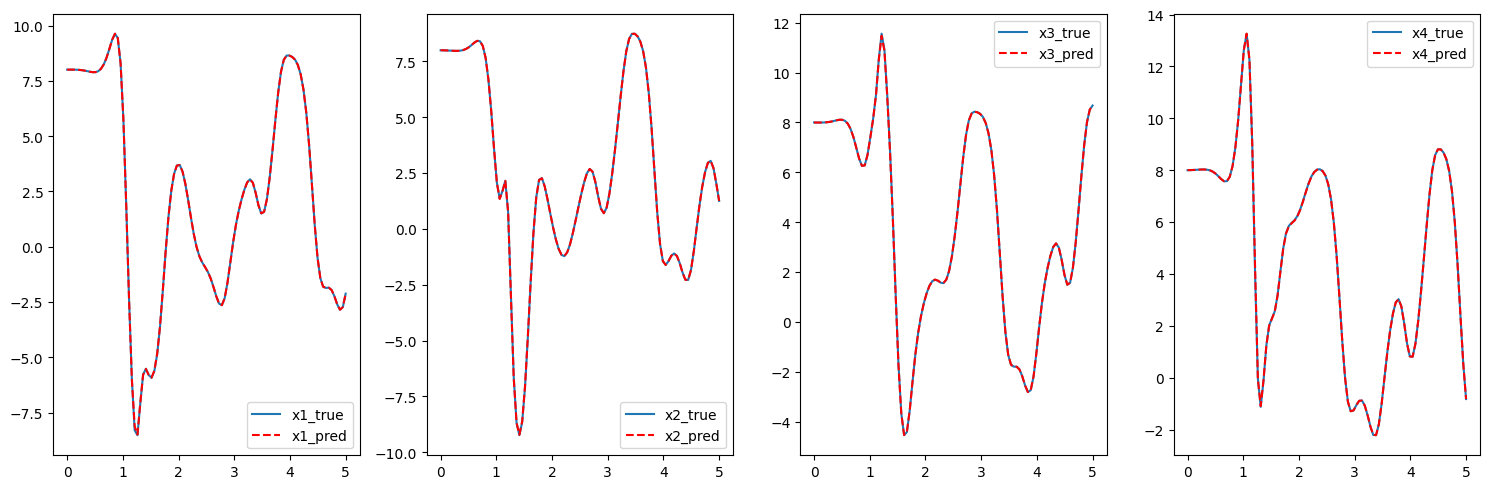

In [48]:
model.compile(optimizer="adam", lr=1e-4)
losshistory, train_state = model.train(iterations=2000)

y = model.predict(t.reshape(t.shape[0], 1))

fig, axs = plt.subplots(1, 4, figsize=(15, 5))
# x(t)
axs[0].plot(t, x[:,:1], label='x1_true')
axs[0].plot(t, y[:,:1], "r--", label='x1_pred')
axs[0].legend()

# y(t)
axs[1].plot(t, x[:,1:2], label='x2_true')
axs[1].plot(t, y[:,1:2], "r--", label='x2_pred')
axs[1].legend()

# z(t)
axs[2].plot(t, x[:,2:3], label='x3_true')
axs[2].plot(t, y[:,2:3], "r--", label='x3_pred')
axs[2].legend()

# z(t)
axs[3].plot(t, x[:,3:], label='x4_true')
axs[3].plot(t, y[:,3:], "r--", label='x4_pred')
axs[3].legend()

plt.tight_layout()
plt.show()

## Kuramoto-Sivashinsky equation

$$u_t = -uu_x - u_{xx} - u_{xxxx},  \qquad (x,t)\in [0,32\pi]\times [0,150],$$
with initial condition $$u(x,0) = \cos\left(\frac{x}{16}\right)\left(1+\sin\left(\frac{x}{16}\right)\right),$$
and  periodic boundary conditions. The numerical solution is due to A. Kassam and L. Trefethen ([paper](https://people.maths.ox.ac.uk/trefethen/publication/PDF/2005_111.pdf)).

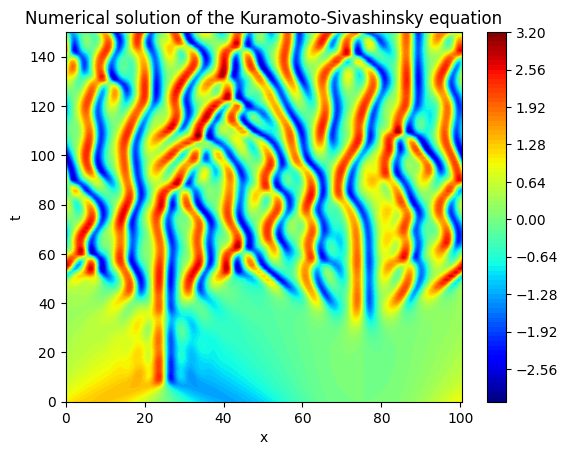

In [ ]:
# u is the initial condition
# h is the time step
# N is the number of points calculated along x
# a is the max value in the initial condition
# b is the min value in the initial condition
# x is used when using a periodic boundary condition, to set up in terms of
#   pi
#
# Initial condition and grid setup
N = 1024
x = np.linspace(0, 32*np.pi, N)
a = -1
b = 1
u = np.cos(x/16)*(1+np.sin(x/16))
v = np.fft.fft(u)
# scalars for ETDRK4
h = 0.25
k = np.concatenate((np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0))) / 16
L = k**2 - k**4
E = np.exp(h*L)
E_2 = np.exp(h*L/2)
M = 16
r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
# main loop
uu = np.array([u])
tt = 0
tmax = 150
nmax = round(tmax/h)
nplt = int((tmax/100)/h)
g = -0.5j*k
for n in range(1, nmax+1):
    t = n*h
    Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
    a = E_2*v + Q*Nv
    Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
    b = E_2*v + Q*Na
    Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
    c = E_2*a + Q*(2*Nb-Nv)
    Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
    if n%nplt == 0:
        u = np.real(np.fft.ifft(v))
        uu = np.append(uu, np.array([u]), axis=0)
        tt = np.hstack((tt, t))
# plot
tt, x = np.meshgrid(tt, x)
plt.contourf(x, tt, uu.T, cmap='jet', levels=100)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Numerical solution of the Kuramoto-Sivashinsky equation')
plt.colorbar()
plt.show()

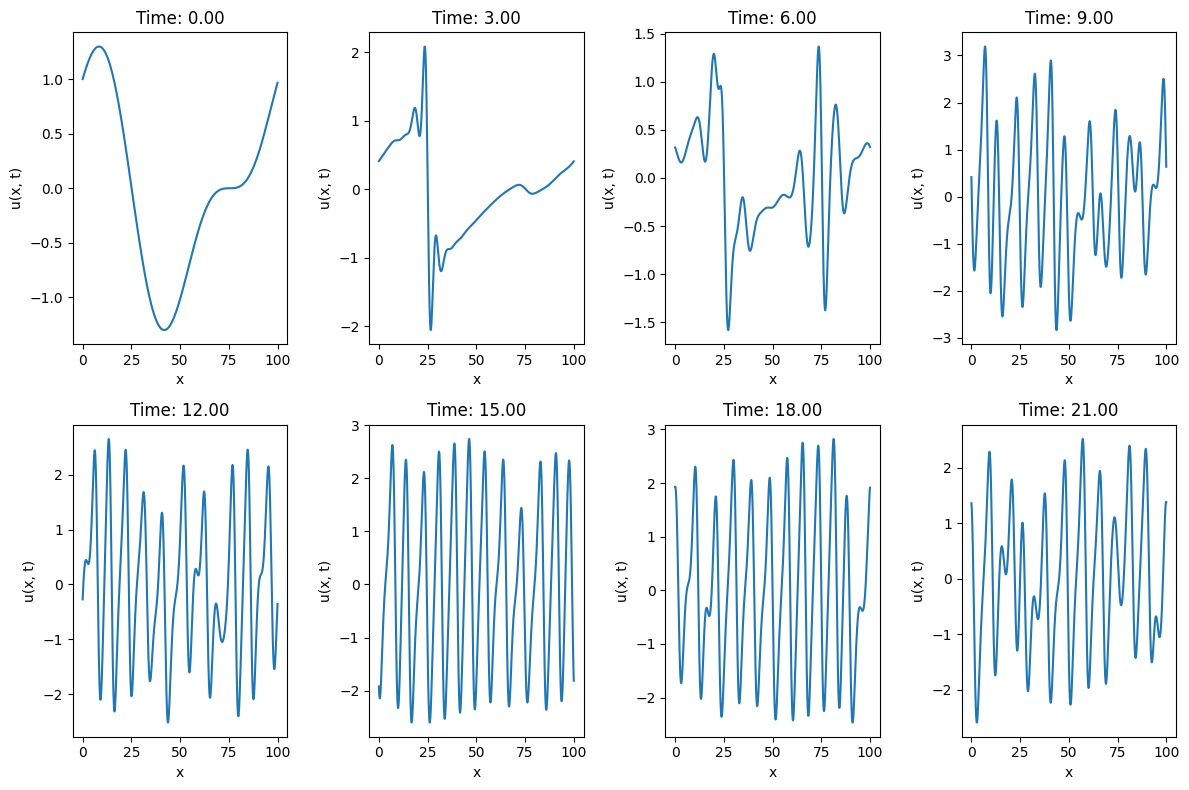

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.plot(np.linspace(0, 100, 1024), uu[12*i])
    plt.title(f'Time: {12*i*h:.2f}')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
plt.tight_layout()
plt.show()

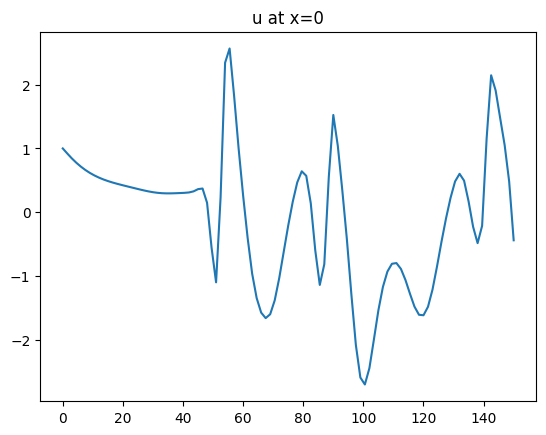

In [ ]:
plt.plot(tt[0,:], uu[:,0])
plt.title("u at x=0")
plt.show()

In [ ]:
def ks_eq(z, u):
    # z = (x, y)
    u_x = dde.grad.jacobian(u, z, i=0, j=0)
    u_xx = dde.grad.hessian(u, z, i=0, j=0)
    u_xxxx = dde.grad.hessian(u_xx, z, i=0, j=0)
    u_t = dde.grad.jacobian(u, z, i=0, j=1)
    return u_t + u*u_x + u_xx + u_xxxx

geom = dde.geometry.Interval(0, 32*np.pi)
timedomain = dde.geometry.TimeDomain(0, 150)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary(_, on_boundary):
    return on_boundary

def boundary_ic(z, _):
    return dde.utils.isclose(z[1], 0.0)

def boundary_lr(z, _):
    return dde.utils.isclose(z[0], 0.0) or dde.utils.isclose(z[0], 32*np.pi)

def func_bc(z, u, _):
    return dde.grad.jacobian(u, z, i=0, j=0)

ic = dde.icbc.IC(geomtime, lambda z: tf.cos(z[:,0:1]/16)*(1+tf.sin(z[:,0:1]/16)), boundary_ic)
# bc1 = dde.icbc.DirichletBC(geomtime, lambda z: 0, boundary_lr)
# bc2 = dde.icbc.OperatorBC(geomtime, func_bc, boundary_lr)

bc1 = dde.icbc.PeriodicBC(geomtime, 0, boundary, derivative_order=0)
bc2 = dde.icbc.PeriodicBC(geomtime, 0, boundary, derivative_order=1)

data = dde.data.TimePDE(
    geomtime,
    ks_eq,
    [ic, bc1, bc2],
    num_domain=400,
    num_boundary=160,
    num_initial=100
)

net = dde.nn.FNN(
    [2] + [64] * 4 + [1], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [ ]:
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=4000)

Compiling model...
Building feed-forward neural network...
'build' took 0.226433 s

'compile' took 10.034083 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.18e-04, 7.46e-01, 6.51e-02, 8.97e-04]    [5.18e-04, 7.46e-01, 6.51e-02, 8.97e-04]    []  
1000      [7.83e-04, 1.31e-02, 1.72e-04, 3.04e-05]    [7.83e-04, 1.31e-02, 1.72e-04, 3.04e-05]    []  
2000      [6.82e-04, 1.03e-02, 1.18e-04, 1.06e-05]    [6.82e-04, 1.03e-02, 1.18e-04, 1.06e-05]    []  
3000      [4.09e-04, 7.27e-03, 5.87e-05, 9.09e-06]    [4.09e-04, 7.27e-03, 5.87e-05, 9.09e-06]    []  
4000      [3.63e-04, 1.08e-03, 1.64e-05, 2.14e-06]    [3.63e-04, 1.08e-03, 1.64e-05, 2.14e-06]    []  

Best model at step 4000:
  train loss: 1.46e-03
  test loss: 1.46e-03
  test metric: []

'train' took 703.018840 s



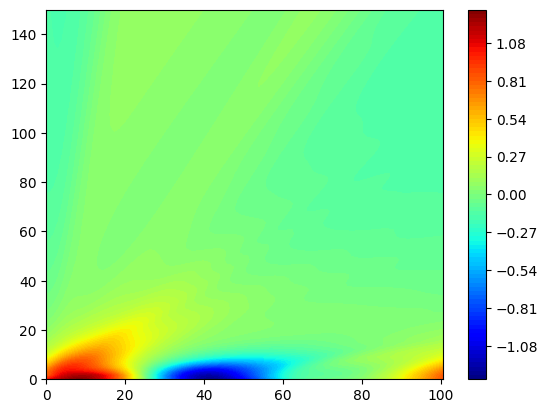

In [ ]:
t = np.linspace(0, 150, 100)
x = np.linspace(0, 32*np.pi, 100)
X, T = np.meshgrid(x, t)
u_pred = model.predict(np.stack([X.flatten(), T.flatten()], 1)).reshape(100, 100)
plt.contourf(X, T, u_pred, cmap="jet", levels=100)
plt.colorbar()
plt.show()

## Lid-driven cavity problem

$$\frac{\partial u}{\partial t}+u\frac{\partial u}{\partial x}+v\frac{\partial u}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial x}+\nu \left(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2} \right) $$


$$\frac{\partial v}{\partial t}+u\frac{\partial v}{\partial x}+v\frac{\partial v}{\partial y} = -\frac{1}{\rho}\frac{\partial p}{\partial y}+\nu\left(\frac{\partial^2 v}{\partial x^2}+\frac{\partial^2 v}{\partial y^2}\right) $$

$$\frac{\partial^2 p}{\partial x^2}+\frac{\partial^2 p}{\partial y^2} = -\rho\left(\frac{\partial u}{\partial x}\frac{\partial u}{\partial x}+2\frac{\partial u}{\partial y}\frac{\partial v}{\partial x}+\frac{\partial v}{\partial y}\frac{\partial v}{\partial y} \right)$$
with the initial condition $$u, v, p = 0 \; \text{everywhere},$$ and the boundary conditions
\begin{array}{l}
u=1\quad \text{at}\; y=2,\\
u, v=0 \quad \text{on the other boundaries},\\
\frac{\partial p}{\partial y}=0 \quad \text{at} \; y=0,\\
p=0\quad \text{at} \; y=2,\\
\frac{\partial p}{\partial x}=0 \quad\text{at} \; x=0,2.
\end{array}

In [4]:
nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)

rho = 1
nu = 0.1
dt = 0.001

u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
def build_up_b(b, rho, dt, u, v, dx, dy):

    b[1:-1, 1:-1] = (rho * (1 / dt *
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) /
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b
def pressure_poisson(p, dx, dy, b):
    pn = np.empty_like(p)
    pn = p.copy()

    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 +
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) *
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2

    return p

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    un = np.empty_like(u)
    vn = np.empty_like(v)
    b = np.zeros((ny, nx))

    for n in range(nt):
        un = u.copy()
        vn = v.copy()

        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)

        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0


    return u, v, p

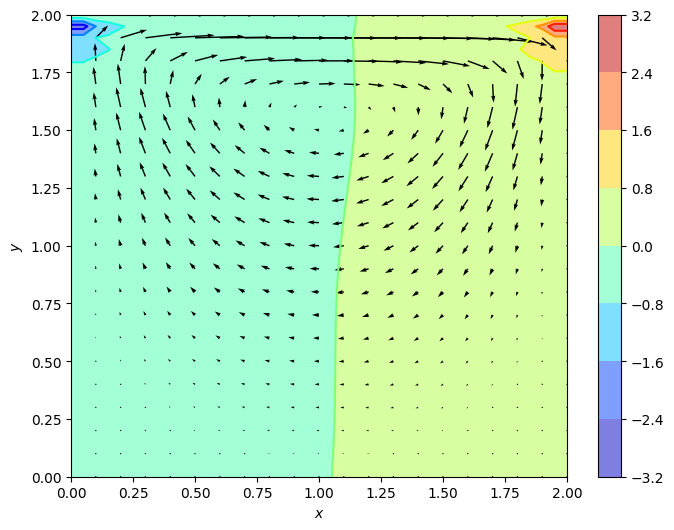

In [5]:
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap="jet")
plt.colorbar()
plt.contour(X, Y, p, cmap="jet")
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [6]:
def lid_pde(z, f):
    # z = (x, y, t)
    # f = (u, v, p)
    u, v, p = f[:,:1], f[:,1:2], f[:,2:]
    u_t = dde.grad.jacobian(f, z, i=0, j=2)
    v_t = dde.grad.jacobian(f, z, i=1, j=2)
    u_x = dde.grad.jacobian(f, z, i=0, j=0)
    u_y = dde.grad.jacobian(f, z, i=0, j=1)
    v_x = dde.grad.jacobian(f, z, i=1, j=0)
    v_y = dde.grad.jacobian(f, z, i=1, j=1)
    u_xx = dde.grad.hessian(f, z, i=0, j=0, component=0)
    u_yy = dde.grad.hessian(f, z, i=1, j=1, component=0)
    v_xx = dde.grad.hessian(f, z, i=0, j=0, component=1)
    v_yy = dde.grad.hessian(f, z, i=1, j=1, component=1)
    p_x = dde.grad.jacobian(f, z, i=2, j=0)
    p_y = dde.grad.jacobian(f, z, i=2, j=1)
    p_xx = dde.grad.hessian(f, z, i=0, j=0, component=2)
    p_yy = dde.grad.hessian(f, z, i=1, j=1, component=2)

    res1 = u_t + u*u_x + v*u_y + p_x/rho - nu*(u_xx + u_yy)
    res2 = v_t + u*v_x + v*v_y + p_y/rho - nu*(v_xx + v_yy)
    res3 = p_xx + p_yy + rho*(u_x**2 + 2*u_y*v_x + v_y**2)
    return res1, res2, res3

geom = dde.geometry.Rectangle([0, 0], [2, 2])
timedomain = dde.geometry.TimeDomain(0.0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def boundary_ic(z, _):
    return dde.utils.isclose(z[2], 0.0)

def boundary_l(z, _):
    return dde.utils.isclose(z[0], 0.0)
def boundary_r(z, _):
    return dde.utils.isclose(z[0], 2.)
def boundary_t(z, _):
    return dde.utils.isclose(z[1], 2.)
def boundary_b(z, _):
    return dde.utils.isclose(z[1], 0.0)
def boundary_lr(z, _):
    return dde.utils.isclose(z[0], 0.0) or dde.utils.isclose(z[0], 2.)
def boundary_tb(z, _):
    return dde.utils.isclose(z[1], 0.0) or dde.utils.isclose(z[1], 2.)

def py_bc(z, f, _):
    return dde.grad.jacobian(f, z, i=2, j=1)
def px_bc(z, f, _):
    return dde.grad.jacobian(f, z, i=2, j=0)

# ICs
ic1 = dde.icbc.IC(geomtime, lambda z: 0.0, boundary_ic, component=0)
ic2 = dde.icbc.IC(geomtime, lambda z: 0.0, boundary_ic, component=1)
ic3 = dde.icbc.IC(geomtime, lambda z: 0.0, boundary_ic, component=2)
# BCs for u
bc1 = dde.icbc.DirichletBC(geomtime, lambda z: 1.0, boundary_t, component=0)
bc2 = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_b, component=0)
bc3 = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_lr, component=0)
# BCs for v
bc4 = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_tb, component=1)
bc5 = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_lr, component=1)
# BCs for p
bc6 = dde.icbc.DirichletBC(geomtime, lambda z: 0.0, boundary_t, component=2)
bc7 = dde.icbc.OperatorBC(geomtime, py_bc, boundary_b)
bc8 = dde.icbc.OperatorBC(geomtime, px_bc, boundary_lr)

data = dde.data.TimePDE(
    geomtime,
    lid_pde,
    [ic1, ic2, ic3, bc1, bc2, bc3, bc4, bc5, bc6, bc7, bc8],
    num_domain=5000,
    num_boundary=1000,
    num_initial=400,
)

net = dde.nn.FNN(
    [3] + [128] * 4 + [3], "tanh", "Glorot uniform"
)

model = dde.Model(data, net)

In [27]:
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(iterations=10000)

Compiling model...
'compile' took 3.231728 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
34200     [4.86e-04, 2.16e-04, 4.38e-04, 8.38e-04, 6.73e-06, 2.23e-06, 3.50e-03, 2.36e-06, 4.39e-03, 3.78e-05, 8.54e-05, 8.11e-05, 2.90e-06, 6.78e-05]    [4.86e-04, 2.16e-04, 4.38e-04, 8.38e-04, 6.73e-06, 2.23e-06, 3.50e-03, 2.36e-06, 4.39e-03, 3.78e-05, 8.54e-05, 8.11e-05, 2.90e-06, 6.78e-05]    []  
35000     [4.85e-04, 2.17e-04, 4.19e-04, 8.28e-04, 6.98e-06, 2.23e-06, 3.48e-03, 2.41e-06, 4.36e-03, 3.72e-05, 8.53e-05, 8.15e-05, 2.87e-06, 6.82e-05]    [4.85e-04, 2.17e-04, 4.19e-04, 8.28e-04, 6.98e-06, 2.23e-06, 3.48e-03, 2.41e-06, 4.36e-03, 3.72e-05, 8.53e-05, 8.15e-05, 2.87e-06, 6.82e-05]    []  
36000     [4.81e-04

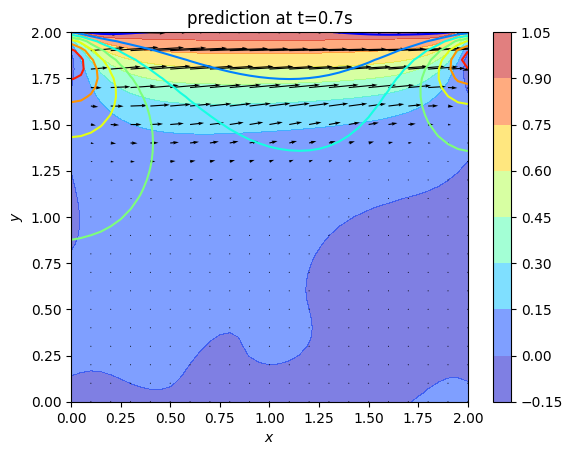

In [28]:
x = np.linspace(0, 2, 41)
y = np.linspace(0, 2, 41)
X, Y = np.meshgrid(x, y)
pred = model.predict(np.stack([X.flatten(), Y.flatten(), [0.7]*41*41], 1))

plt.contourf(X, Y, pred[:,0:1].reshape(41, 41), alpha=0.5, cmap="jet")
plt.colorbar()
plt.contour(X, Y, pred[:,2:3].reshape(41, 41), cmap="jet")
plt.quiver(X[::2, ::2], Y[::2, ::2], pred[:,0:1].reshape(41, 41)[::2, ::2], pred[:,1:2].reshape(41, 41)[::2, ::2])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title("prediction at t=0.7s")
plt.show()

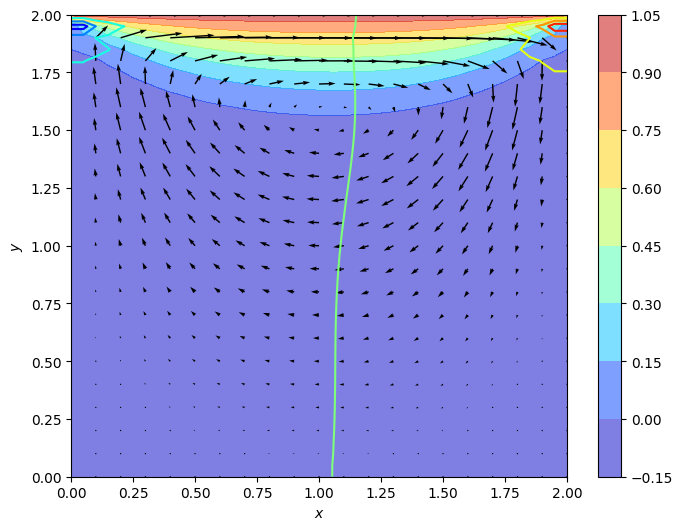

In [15]:
x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)
X, Y = np.meshgrid(x, y)
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))
b = np.zeros((ny, nx))
nt = 700
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)

fig = plt.figure(figsize=(8, 6), dpi=100)
plt.contourf(X, Y, u, alpha=0.5, cmap="jet")
plt.colorbar()
plt.contour(X, Y, p, cmap="jet")
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()